In [6]:
!pip install ogb

In [7]:
from torch_scatter import scatter_softmax, scatter_mean

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Embedding, ModuleList
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_scatter import scatter, scatter_mean, scatter_add, scatter_sum
from torch_geometric.nn import GINConv, GINEConv


class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(AtomEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(9):
            self.embeddings.append(Embedding(100, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])
        return out


class BondEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(BondEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(3):
            self.embeddings.append(Embedding(6, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, edge_attr):
        if edge_attr.dim() == 1:
            edge_attr = edge_attr.unsqueeze(1)

        out = 0
        for i in range(edge_attr.size(1)):
            out += self.embeddings[i](edge_attr[:, i])
        return out


class Global_Gen_Sum_Mean_Max_Pool(nn.Module):
    def __init__(self, family = "softmax", p = 1.0, beta = 1.0, 
                 trainable_p = False, trainable_beta = False):
        r"""Performs batch-wise graph-level-outputs by transforming node
        features based on a Generalized Aggr-Mean-Max function, so that
        for a single graph :math:`\mathcal{G}_i` its output is computed
        deppending on the family of transformations by:
        .. math::
            \mathbf{r}_i = \frac{1}{\beta*N_i} \sum_{n=1}^{N_i} \mathbf{softmax} \left( \mathbf{x}_n * p \right) * \mathbf{x}_n
        for softmax aggregation or
        .. math::
            \mathbf{r}_i = \left( \frac{1}{\beta*N_i} \sum_{n=1}^{N_i} \mathbf{x}_n^{p} \right)^{1/p}
        for power mean aggregation.

        Args:
            family (str): family of generalized mean-max functions to use. 
                Either "softmax" or "power" for eq. 1 or eq. 2 respectively.
            p (float): parameter for the generalized mean-max function
            trainable (bool): whether the value of p is learnable during training.
        """
        super(Global_Gen_Sum_Mean_Max_Pool, self).__init__()
        
        self.family         = family
        self.base_p         = p
        self.base_beta      = beta
        self.trainable_p    = trainable_p
        self.trainable_beta = trainable_beta
        # define params
        self.p = torch.nn.Parameter(torch.tensor([p], device=device),
                                    requires_grad=trainable_p)# .to(device)
        self.beta = torch.nn.Parameter(torch.tensor([beta], device=device),
                                       requires_grad=trainable_beta)# .to(device)

    def forward(self, x, batch, bsize=None):
        r"""Args:
            x (Tensor): Node feature matrix
                :math:`\mathbf{X} \in \mathbb{R}^{(N_1 + \ldots + N_B) \times F}`.
            batch (LongTensor): Batch vector :math:`\mathbf{b} \in {\{ 0, \ldots,
                B-1\}}^N`, which assigns each node to a specific example.
            size (int, optional): Batch-size :math:`B`.
                Automatically calculated if not given. (default: :obj:`None`)
        :rtype: :class:`Tensor`
        """
        bsize = int(batch.max().item() + 1) if bsize is None else bsize
        n_nodes = scatter_sum(torch.ones_like(x), batch, dim=0, dim_size=bsize)
        if self.family == "softmax":
            out = scatter_softmax(self.p * x.detach(), batch, dim=0)
            return scatter_add(x * out,
                                batch, dim=0, dim_size=bsize)*n_nodes / (1+self.beta*(n_nodes-1))

        elif self.family == "power":
            # numerical stability - avoid powers of large numbers or negative ones
            min_x, max_x = 1e-7, 1e+3
            torch.clamp_(x, min_x, max_x)
            out = scatter_add(torch.pow(x, self.p),
                               batch, dim=0, dim_size=bsize) / (1+self.beta*(n_nodes-1))
            torch.clamp_(out, min_x, max_x)
            return torch.pow(out, 1 / self.p)


    def reset_parameters(self):
        if self.p and torch.is_tensor(self.p):
            self.p.data.fill_(self.base_p)
        if self.beta and torch.is_tensor(self.beta):
            self.beta.data.fill_(self.base_beta)


    def __repr__(self):
        return "Generalized Aggr-Mean-Max global pooling layer with params:" + \
               str({"family": self.family,
                    "base_p": self.base_p,
                    "base_beta"     : self.base_beta,
                    "trainable_p"   : self.trainable_p,
                    "trainable_beta": self.trainable_beta})



class Net(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, dropout=0.0,
                 inter_message_passing=True):
        super(Net, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.inter_message_passing = inter_message_passing

        self.atom_encoder = AtomEncoder(hidden_channels)
        self.clique_encoder = Embedding(4, hidden_channels)

        self.bond_encoders = ModuleList()
        self.atom_convs = ModuleList()
        self.atom_batch_norms = ModuleList()
        self.reader = Global_Gen_Sum_Mean_Max_Pool(family = "softmax", p = 1.0, beta = 1.0, 
                                                   trainable_p = True, trainable_beta = True)

        for _ in range(num_layers):
            self.bond_encoders.append(BondEncoder(hidden_channels))
            nn = Sequential(
                Linear(hidden_channels, 2 * hidden_channels),
                BatchNorm1d(2 * hidden_channels),
                ReLU(),
                Linear(2 * hidden_channels, hidden_channels),
            )
            self.atom_convs.append(GINEConv(nn, train_eps=True))
            self.atom_batch_norms.append(BatchNorm1d(hidden_channels))

        self.clique_convs = ModuleList()
        self.clique_batch_norms = ModuleList()

        for _ in range(num_layers):
            nn = Sequential(
                Linear(hidden_channels, 2 * hidden_channels),
                BatchNorm1d(2 * hidden_channels),
                ReLU(),
                Linear(2 * hidden_channels, hidden_channels),
            )
            self.clique_convs.append(GINConv(nn, train_eps=True))
            self.clique_batch_norms.append(BatchNorm1d(hidden_channels))

        self.atom2clique_lins = ModuleList()
        self.clique2atom_lins = ModuleList()

        for _ in range(num_layers):
            self.atom2clique_lins.append(
                Linear(hidden_channels, hidden_channels))
            self.clique2atom_lins.append(
                Linear(hidden_channels, hidden_channels))

        self.atom_lin = Linear(hidden_channels, hidden_channels)
        self.clique_lin = Linear(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def reset_parameters(self):
        self.atom_encoder.reset_parameters()
        self.clique_encoder.reset_parameters()

        for emb, conv, batch_norm in zip(self.bond_encoders, self.atom_convs,
                                         self.atom_batch_norms):
            emb.reset_parameters()
            conv.reset_parameters()
            batch_norm.reset_parameters()

        for conv, batch_norm in zip(self.clique_convs,
                                    self.clique_batch_norms):
            conv.reset_parameters()
            batch_norm.reset_parameters()

        for lin1, lin2 in zip(self.atom2clique_lins, self.clique2atom_lins):
            lin1.reset_parameters()
            lin2.reset_parameters()

        self.atom_lin.reset_parameters()
        self.clique_lin.reset_parameters()
        self.lin.reset_parameters()
        self.reader.reset_parameters()

    def forward(self, data):
        x = self.atom_encoder(data.x.squeeze())

        if self.inter_message_passing:
            x_clique = self.clique_encoder(data.x_clique.squeeze())

        for i in range(self.num_layers):
            edge_attr = self.bond_encoders[i](data.edge_attr)
            x = self.atom_convs[i](x, data.edge_index, edge_attr)
            x = self.atom_batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)

            if self.inter_message_passing:
                row, col = data.atom2clique_index

                x_clique = x_clique + F.relu(self.atom2clique_lins[i](scatter(
                    x[row], col, dim=0, dim_size=x_clique.size(0),
                    reduce='mean')))

                x_clique = self.clique_convs[i](x_clique, data.tree_edge_index)
                x_clique = self.clique_batch_norms[i](x_clique)
                x_clique = F.relu(x_clique)
                x_clique = F.dropout(x_clique, self.dropout,
                                     training=self.training)

                x = x + F.relu(self.clique2atom_lins[i](scatter(
                    x_clique[col], row, dim=0, dim_size=x.size(0),
                    reduce='mean')))

        x = self.reader(x, data.batch)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.atom_lin(x)

        if self.inter_message_passing:
            tree_batch = torch.repeat_interleave(data.num_cliques)
            x_clique = scatter(x_clique, tree_batch, dim=0, dim_size=x.size(0),
                               reduce='mean')
            x_clique = F.dropout(x_clique, self.dropout,
                                 training=self.training)
            x_clique = self.clique_lin(x_clique)
            x = x + x_clique

        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.lin(x)
        return x

In [19]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import tree_decomposition

from rdkit import Chem
from rdkit.Chem.rdchem import BondType

bonds = [BondType.SINGLE, BondType.DOUBLE, BondType.TRIPLE, BondType.AROMATIC]


def mol_from_data(data):
    mol = Chem.RWMol()

    x = data.x if data.x.dim() == 1 else data.x[:, 0]
    for z in x.tolist():
        mol.AddAtom(Chem.Atom(z))

    row, col = data.edge_index
    mask = row < col
    row, col = row[mask].tolist(), col[mask].tolist()

    bond_type = data.edge_attr
    bond_type = bond_type if bond_type.dim() == 1 else bond_type[:, 0]
    bond_type = bond_type[mask].tolist()

    for i, j, bond in zip(row, col, bond_type):
        assert bond >= 1 and bond <= 4
        mol.AddBond(i, j, bonds[bond - 1])

    return mol.GetMol()


class JunctionTreeData(Data):
    def __inc__(self, key, item):
        if key == 'tree_edge_index':
            return self.x_clique.size(0)
        elif key == 'atom2clique_index':
            return torch.tensor([[self.x.size(0)], [self.x_clique.size(0)]])
        else:
            return super(JunctionTreeData, self).__inc__(key, item)


class JunctionTree(object):
    def __call__(self, data):
        mol = mol_from_data(data)
        out = tree_decomposition(mol, return_vocab=True)
        tree_edge_index, atom2clique_index, num_cliques, x_clique = out

        data = JunctionTreeData(**{k: v for k, v in data})

        data.tree_edge_index = tree_edge_index
        data.atom2clique_index = atom2clique_index
        data.num_cliques = num_cliques
        data.x_clique = x_clique

        return data

In [20]:
# edit the function causing the error: add argument chem=None + modify function code: 
# Chem=chem if chem is not None else Chem

# tree_decomposition(Chem.MolFromSmiles("cicccc1c"), return_vocab=True)
# once modified and saved, restart the environmnet, comment this cell and run the experiment.

In [21]:
import argparse

import torch
from torch.optim import Adam
import numpy as np
from sklearn.metrics import roc_auc_score

from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader
from torch_geometric.transforms import Compose

class Argparse_emulate():
    def __init__(self, device=0, hidden_channels=256, num_layers=2, dropout=0.5,
               epochs=100, no_inter_message_passing="store_true"):
        self.device = device
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout
        self.epochs = epochs
        self.no_inter_message_passing = no_inter_message_passing
        return

args = Argparse_emulate()
# parser.add_argument('--device', type=int, default=0)
# parser.add_argument('--hidden_channels', type=int, default=256)
# parser.add_argument('--num_layers', type=int, default=2)
# parser.add_argument('--dropout', type=float, default=0.5)
# parser.add_argument('--epochs', type=int, default=100)
# parser.add_argument('--no_inter_message_passing', action='store_true')
# args = parser.parse_args()
# print(args)


class OGBTransform(object):
    # OGB saves atom and bond types zero-index based. We need to revert that.
    def __call__(self, data):
        data.x[:, 0] += 1
        data.edge_attr[:, 0] += 1
        return data


transform = Compose([OGBTransform(), JunctionTree()])

name = 'ogbg-molhiv'
dataset = PygGraphPropPredDataset(name, 'data', pre_transform=transform)

dataset = dataset.shuffle()
num_train, num_trainval = round(0.8 * len(dataset)), round(0.9 * len(dataset))
train_dataset = dataset[:num_train]
val_dataset = dataset[num_train:num_trainval]
test_dataset = dataset[num_trainval:]

train_loader = DataLoader(train_dataset, 128, shuffle=True)
val_loader = DataLoader(val_dataset, 128, shuffle=False)
test_loader = DataLoader(test_dataset, 128, shuffle=False)


device = f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu'

In [22]:
def train(epoch, vals=False):
    values = []
    model.train()

    total_loss = 0
    for i,data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        mask = ~torch.isnan(data.y)
        out = model(data)[mask]
        y = data.y.to(torch.float)[mask]
        loss = torch.nn.BCEWithLogitsLoss()(out, y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
        # record beta and p values
        if vals:
            # display computational graph
            # global g
            #g = make_dot(out)
            # "a"+9
            values_batch = {}
            values_batch["p"]    = model.reader.p.detach().cpu().numpy()
            values_batch["beta"] = model.reader.beta.detach().cpu().numpy()
            values.append(values_batch)
            if False: # i==0:
                print("records:", i, "value:", values_batch)


    return total_loss / len(train_loader.dataset), values


@torch.no_grad()
def test(loader):
    model.eval()

    y_preds, y_trues = [], []
    for data in loader:
        data = data.to(device)
        y_preds.append(model(data))
        y_trues.append(data.y)

    y_pred = torch.cat(y_preds, dim=0).cpu().numpy()
    y_true = torch.cat(y_trues, dim=0).cpu().numpy()

    rocauc_list = []
    for i in range(y_true.shape[1]):
        # AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:, i] == 1) > 0 and np.sum(y_true[:, i] == 0) > 0:
            # ignore nan values
            is_labeled = y_true[:, i] == y_true[:, i]
            rocauc_list.append(
                roc_auc_score(y_true[is_labeled, i], y_pred[is_labeled, i]))

    return {"rocauc": sum(rocauc_list) / len(rocauc_list)}


values     = []
test_perfs = []
for run in range(10):
    print()
    print(f'Run {run}:')
    print()
    model = Net(hidden_channels=args.hidden_channels,
            out_channels=dataset.num_tasks, num_layers=args.num_layers,
            dropout = args.dropout if run<10 else 0.6, # edited to increase dropout
            inter_message_passing=not args.no_inter_message_passing).to(device)

    model.reset_parameters()
    optimizer = Adam(model.parameters(), lr=0.0001)

    best_val_perf = test_perf = 0
    for epoch in range(1, args.epochs + 1):
        loss, epoch_values = train(epoch, vals=True)
        train_perf = test(train_loader)
        val_perf = test(val_loader)

        if val_perf["rocauc"] > best_val_perf:
            best_val_perf = val_perf["rocauc"]
            test_perf = test(test_loader)

        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_perf["rocauc"]:.4f}, Val: {val_perf["rocauc"]:.4f}, '
              f'Test: {test_perf["rocauc"]:.4f}')
        if epoch % 10 == 0:
            print("Recorded values:", epoch_values)

    test_perfs.append(test_perf["rocauc"])
    values.append(epoch_values[-1])

test_perf = torch.tensor(test_perfs)
print('===========================')
print(f'Final Test: {test_perf.mean():.4f} ± {test_perf.std():.4f}')


Run 0:

Epoch: 001, Loss: 0.1762, Train: 0.7153, Val: 0.7294, Test: 0.7357
Epoch: 002, Loss: 0.1562, Train: 0.7375, Val: 0.7382, Test: 0.7391
Epoch: 003, Loss: 0.1516, Train: 0.7520, Val: 0.7573, Test: 0.7608
Epoch: 004, Loss: 0.1467, Train: 0.7713, Val: 0.7651, Test: 0.7659
Epoch: 005, Loss: 0.1440, Train: 0.7756, Val: 0.7675, Test: 0.7748
Epoch: 006, Loss: 0.1409, Train: 0.7822, Val: 0.7812, Test: 0.7747
Epoch: 007, Loss: 0.1390, Train: 0.7859, Val: 0.7889, Test: 0.7675
Epoch: 008, Loss: 0.1375, Train: 0.7939, Val: 0.7780, Test: 0.7675
Epoch: 009, Loss: 0.1362, Train: 0.8055, Val: 0.7967, Test: 0.7885
Epoch: 010, Loss: 0.1356, Train: 0.8064, Val: 0.7991, Test: 0.7836
Recorded values: [{'p': array([0.96712524], dtype=float32), 'beta': array([1.0168399], dtype=float32)}, {'p': array([0.9671017], dtype=float32), 'beta': array([1.0168493], dtype=float32)}, {'p': array([0.9670857], dtype=float32), 'beta': array([1.0168506], dtype=float32)}, {'p': array([0.9670655], dtype=float32), 'beta'

Epoch: 011, Loss: 0.1316, Train: 0.8091, Val: 0.7831, Test: 0.7836
Epoch: 012, Loss: 0.1326, Train: 0.8104, Val: 0.7961, Test: 0.7836
Epoch: 013, Loss: 0.1294, Train: 0.7988, Val: 0.7720, Test: 0.7836
Epoch: 014, Loss: 0.1310, Train: 0.8208, Val: 0.8086, Test: 0.7960
Epoch: 015, Loss: 0.1282, Train: 0.8270, Val: 0.8018, Test: 0.7960
Epoch: 016, Loss: 0.1275, Train: 0.8299, Val: 0.8038, Test: 0.7960
Epoch: 017, Loss: 0.1259, Train: 0.8321, Val: 0.8063, Test: 0.7960
Epoch: 018, Loss: 0.1256, Train: 0.8187, Val: 0.7805, Test: 0.7960
Epoch: 019, Loss: 0.1246, Train: 0.8209, Val: 0.7767, Test: 0.7960
Epoch: 020, Loss: 0.1241, Train: 0.8356, Val: 0.7981, Test: 0.7960
Recorded values: [{'p': array([0.94225055], dtype=float32), 'beta': array([1.0264763], dtype=float32)}, {'p': array([0.9421486], dtype=float32), 'beta': array([1.0265638], dtype=float32)}, {'p': array([0.9420566], dtype=float32), 'beta': array([1.02664], dtype=float32)}, {'p': array([0.9419679], dtype=float32), 'beta': array([1.

Epoch: 021, Loss: 0.1242, Train: 0.8443, Val: 0.8164, Test: 0.8043
Epoch: 022, Loss: 0.1222, Train: 0.8406, Val: 0.8051, Test: 0.8043
Epoch: 023, Loss: 0.1242, Train: 0.8469, Val: 0.8088, Test: 0.8043
Epoch: 024, Loss: 0.1204, Train: 0.8472, Val: 0.8057, Test: 0.8043
Epoch: 025, Loss: 0.1217, Train: 0.8472, Val: 0.7987, Test: 0.8043
Epoch: 026, Loss: 0.1209, Train: 0.8420, Val: 0.7801, Test: 0.8043
Epoch: 027, Loss: 0.1197, Train: 0.8478, Val: 0.8072, Test: 0.8043
Epoch: 028, Loss: 0.1174, Train: 0.8512, Val: 0.8152, Test: 0.8043
Epoch: 029, Loss: 0.1176, Train: 0.8547, Val: 0.8180, Test: 0.8097
Epoch: 030, Loss: 0.1188, Train: 0.8652, Val: 0.8164, Test: 0.8097
Recorded values: [{'p': array([0.91733575], dtype=float32), 'beta': array([1.0358078], dtype=float32)}, {'p': array([0.917371], dtype=float32), 'beta': array([1.0357575], dtype=float32)}, {'p': array([0.9173865], dtype=float32), 'beta': array([1.0357286], dtype=float32)}, {'p': array([0.9173915], dtype=float32), 'beta': array([1

Epoch: 031, Loss: 0.1179, Train: 0.8594, Val: 0.8177, Test: 0.8097
Epoch: 032, Loss: 0.1165, Train: 0.8654, Val: 0.8059, Test: 0.8097
Epoch: 033, Loss: 0.1157, Train: 0.8660, Val: 0.8193, Test: 0.8113
Epoch: 034, Loss: 0.1161, Train: 0.8634, Val: 0.8187, Test: 0.8113
Epoch: 035, Loss: 0.1155, Train: 0.8613, Val: 0.8201, Test: 0.8160
Epoch: 036, Loss: 0.1141, Train: 0.8640, Val: 0.8199, Test: 0.8160
Epoch: 037, Loss: 0.1143, Train: 0.8653, Val: 0.8056, Test: 0.8160
Epoch: 038, Loss: 0.1147, Train: 0.8691, Val: 0.8059, Test: 0.8160
Epoch: 039, Loss: 0.1153, Train: 0.8733, Val: 0.8180, Test: 0.8160
Epoch: 040, Loss: 0.1146, Train: 0.8662, Val: 0.8047, Test: 0.8160
Recorded values: [{'p': array([0.8945867], dtype=float32), 'beta': array([1.0441147], dtype=float32)}, {'p': array([0.8945968], dtype=float32), 'beta': array([1.0440902], dtype=float32)}, {'p': array([0.8946236], dtype=float32), 'beta': array([1.0440576], dtype=float32)}, {'p': array([0.89465445], dtype=float32), 'beta': array([

Epoch: 041, Loss: 0.1127, Train: 0.8831, Val: 0.8145, Test: 0.8160
Epoch: 042, Loss: 0.1117, Train: 0.8770, Val: 0.8236, Test: 0.8246
Epoch: 043, Loss: 0.1110, Train: 0.8828, Val: 0.8164, Test: 0.8246
Epoch: 044, Loss: 0.1110, Train: 0.8808, Val: 0.7997, Test: 0.8246
Epoch: 045, Loss: 0.1109, Train: 0.8796, Val: 0.8136, Test: 0.8246
Epoch: 046, Loss: 0.1109, Train: 0.8765, Val: 0.7980, Test: 0.8246
Epoch: 047, Loss: 0.1110, Train: 0.8810, Val: 0.8170, Test: 0.8246
Epoch: 048, Loss: 0.1109, Train: 0.8851, Val: 0.8213, Test: 0.8246
Epoch: 049, Loss: 0.1098, Train: 0.8826, Val: 0.8065, Test: 0.8246
Epoch: 050, Loss: 0.1078, Train: 0.8905, Val: 0.8140, Test: 0.8246
Recorded values: [{'p': array([0.87423575], dtype=float32), 'beta': array([1.0509716], dtype=float32)}, {'p': array([0.8742409], dtype=float32), 'beta': array([1.0509604], dtype=float32)}, {'p': array([0.87423635], dtype=float32), 'beta': array([1.0509554], dtype=float32)}, {'p': array([0.8742333], dtype=float32), 'beta': array(

Epoch: 051, Loss: 0.1084, Train: 0.8814, Val: 0.8174, Test: 0.8246
Epoch: 052, Loss: 0.1097, Train: 0.8850, Val: 0.8216, Test: 0.8246
Epoch: 053, Loss: 0.1083, Train: 0.8799, Val: 0.8144, Test: 0.8246
Epoch: 054, Loss: 0.1088, Train: 0.8900, Val: 0.8174, Test: 0.8246
Epoch: 055, Loss: 0.1074, Train: 0.8866, Val: 0.8118, Test: 0.8246
Epoch: 056, Loss: 0.1070, Train: 0.8822, Val: 0.8178, Test: 0.8246
Epoch: 057, Loss: 0.1083, Train: 0.8891, Val: 0.8243, Test: 0.8236
Epoch: 058, Loss: 0.1068, Train: 0.8971, Val: 0.8234, Test: 0.8236
Epoch: 059, Loss: 0.1070, Train: 0.8905, Val: 0.8259, Test: 0.8176
Epoch: 060, Loss: 0.1059, Train: 0.8964, Val: 0.8129, Test: 0.8176
Recorded values: [{'p': array([0.857046], dtype=float32), 'beta': array([1.0568815], dtype=float32)}, {'p': array([0.8569215], dtype=float32), 'beta': array([1.056978], dtype=float32)}, {'p': array([0.8568196], dtype=float32), 'beta': array([1.0570534], dtype=float32)}, {'p': array([0.8567388], dtype=float32), 'beta': array([1.0

Epoch: 061, Loss: 0.1061, Train: 0.8950, Val: 0.8128, Test: 0.8176
Epoch: 062, Loss: 0.1058, Train: 0.8974, Val: 0.8231, Test: 0.8176
Epoch: 063, Loss: 0.1063, Train: 0.8976, Val: 0.8207, Test: 0.8176
Epoch: 064, Loss: 0.1040, Train: 0.9033, Val: 0.8220, Test: 0.8176
Epoch: 065, Loss: 0.1033, Train: 0.9045, Val: 0.8297, Test: 0.8350
Epoch: 066, Loss: 0.1037, Train: 0.9007, Val: 0.8177, Test: 0.8350
Epoch: 067, Loss: 0.1024, Train: 0.8927, Val: 0.8162, Test: 0.8350
Epoch: 068, Loss: 0.1046, Train: 0.9048, Val: 0.8219, Test: 0.8350
Epoch: 069, Loss: 0.1035, Train: 0.9006, Val: 0.8114, Test: 0.8350
Epoch: 070, Loss: 0.1037, Train: 0.9065, Val: 0.8213, Test: 0.8350
Recorded values: [{'p': array([0.8417631], dtype=float32), 'beta': array([1.0611743], dtype=float32)}, {'p': array([0.8418032], dtype=float32), 'beta': array([1.0611382], dtype=float32)}, {'p': array([0.84182894], dtype=float32), 'beta': array([1.0611124], dtype=float32)}, {'p': array([0.84186566], dtype=float32), 'beta': array(

Epoch: 071, Loss: 0.1038, Train: 0.9054, Val: 0.8157, Test: 0.8350
Epoch: 072, Loss: 0.1029, Train: 0.9071, Val: 0.8298, Test: 0.8267
Epoch: 073, Loss: 0.1017, Train: 0.9087, Val: 0.8248, Test: 0.8267
Epoch: 074, Loss: 0.1010, Train: 0.9091, Val: 0.8154, Test: 0.8267
Epoch: 075, Loss: 0.1019, Train: 0.9056, Val: 0.8110, Test: 0.8267
Epoch: 076, Loss: 0.1008, Train: 0.8943, Val: 0.7920, Test: 0.8267
Epoch: 077, Loss: 0.1033, Train: 0.9124, Val: 0.8136, Test: 0.8267
Epoch: 078, Loss: 0.0995, Train: 0.9151, Val: 0.8262, Test: 0.8267
Epoch: 079, Loss: 0.1027, Train: 0.9069, Val: 0.8244, Test: 0.8267
Epoch: 080, Loss: 0.0993, Train: 0.9118, Val: 0.8295, Test: 0.8267
Recorded values: [{'p': array([0.8259425], dtype=float32), 'beta': array([1.0658319], dtype=float32)}, {'p': array([0.82593244], dtype=float32), 'beta': array([1.0658267], dtype=float32)}, {'p': array([0.8259166], dtype=float32), 'beta': array([1.0658257], dtype=float32)}, {'p': array([0.82590765], dtype=float32), 'beta': array(

Epoch: 081, Loss: 0.0997, Train: 0.9180, Val: 0.8244, Test: 0.8267
Epoch: 082, Loss: 0.1010, Train: 0.9218, Val: 0.8339, Test: 0.8341
Epoch: 083, Loss: 0.1007, Train: 0.9189, Val: 0.8282, Test: 0.8341
Epoch: 084, Loss: 0.0997, Train: 0.9124, Val: 0.8176, Test: 0.8341
Epoch: 085, Loss: 0.0982, Train: 0.9202, Val: 0.8412, Test: 0.8350
Epoch: 086, Loss: 0.0991, Train: 0.9219, Val: 0.8343, Test: 0.8350
Epoch: 087, Loss: 0.0986, Train: 0.9126, Val: 0.8236, Test: 0.8350
Epoch: 088, Loss: 0.0987, Train: 0.9187, Val: 0.8220, Test: 0.8350
Epoch: 089, Loss: 0.0990, Train: 0.9202, Val: 0.8187, Test: 0.8350
Epoch: 090, Loss: 0.0984, Train: 0.9218, Val: 0.8180, Test: 0.8350
Recorded values: [{'p': array([0.8128202], dtype=float32), 'beta': array([1.0696303], dtype=float32)}, {'p': array([0.81284106], dtype=float32), 'beta': array([1.0696123], dtype=float32)}, {'p': array([0.8128277], dtype=float32), 'beta': array([1.0696243], dtype=float32)}, {'p': array([0.8128119], dtype=float32), 'beta': array([

Epoch: 091, Loss: 0.0969, Train: 0.9264, Val: 0.8276, Test: 0.8350
Epoch: 092, Loss: 0.0968, Train: 0.9253, Val: 0.8232, Test: 0.8350
Epoch: 093, Loss: 0.0967, Train: 0.9234, Val: 0.8243, Test: 0.8350
Epoch: 094, Loss: 0.0965, Train: 0.9222, Val: 0.8113, Test: 0.8350
Epoch: 095, Loss: 0.0971, Train: 0.9291, Val: 0.8374, Test: 0.8350
Epoch: 096, Loss: 0.0960, Train: 0.9277, Val: 0.8245, Test: 0.8350
Epoch: 097, Loss: 0.0971, Train: 0.9274, Val: 0.8285, Test: 0.8350
Epoch: 098, Loss: 0.0956, Train: 0.9197, Val: 0.8230, Test: 0.8350
Epoch: 099, Loss: 0.0957, Train: 0.9313, Val: 0.8177, Test: 0.8350
Epoch: 100, Loss: 0.0954, Train: 0.9249, Val: 0.8225, Test: 0.8350
Recorded values: [{'p': array([0.7977056], dtype=float32), 'beta': array([1.074215], dtype=float32)}, {'p': array([0.7976681], dtype=float32), 'beta': array([1.0742458], dtype=float32)}, {'p': array([0.79764605], dtype=float32), 'beta': array([1.0742606], dtype=float32)}, {'p': array([0.79763633], dtype=float32), 'beta': array([

Epoch: 001, Loss: 0.1805, Train: 0.7111, Val: 0.7109, Test: 0.7204
Epoch: 002, Loss: 0.1564, Train: 0.7304, Val: 0.7302, Test: 0.7395
Epoch: 003, Loss: 0.1517, Train: 0.7443, Val: 0.7433, Test: 0.7485
Epoch: 004, Loss: 0.1476, Train: 0.7552, Val: 0.7566, Test: 0.7549
Epoch: 005, Loss: 0.1439, Train: 0.7596, Val: 0.7552, Test: 0.7549
Epoch: 006, Loss: 0.1414, Train: 0.7663, Val: 0.7538, Test: 0.7549
Epoch: 007, Loss: 0.1391, Train: 0.7842, Val: 0.7645, Test: 0.7778
Epoch: 008, Loss: 0.1366, Train: 0.7950, Val: 0.7840, Test: 0.7867
Epoch: 009, Loss: 0.1361, Train: 0.7948, Val: 0.7788, Test: 0.7867
Epoch: 010, Loss: 0.1353, Train: 0.7757, Val: 0.7520, Test: 0.7867
Recorded values: [{'p': array([0.9636637], dtype=float32), 'beta': array([1.0181795], dtype=float32)}, {'p': array([0.96358293], dtype=float32), 'beta': array([1.0182579], dtype=float32)}, {'p': array([0.96350497], dtype=float32), 'beta': array([1.0183331], dtype=float32)}, {'p': array([0.9634345], dtype=float32), 'beta': array(

Epoch: 011, Loss: 0.1340, Train: 0.8015, Val: 0.7624, Test: 0.7867
Epoch: 012, Loss: 0.1328, Train: 0.8027, Val: 0.7764, Test: 0.7867
Epoch: 013, Loss: 0.1315, Train: 0.8035, Val: 0.7725, Test: 0.7867
Epoch: 014, Loss: 0.1298, Train: 0.8107, Val: 0.7596, Test: 0.7867
Epoch: 015, Loss: 0.1289, Train: 0.8218, Val: 0.7867, Test: 0.7960
Epoch: 016, Loss: 0.1290, Train: 0.8260, Val: 0.7761, Test: 0.7960
Epoch: 017, Loss: 0.1256, Train: 0.8287, Val: 0.7927, Test: 0.8088
Epoch: 018, Loss: 0.1248, Train: 0.8281, Val: 0.8118, Test: 0.8036
Epoch: 019, Loss: 0.1252, Train: 0.8372, Val: 0.7927, Test: 0.8036
Epoch: 020, Loss: 0.1242, Train: 0.8222, Val: 0.7575, Test: 0.8036
Recorded values: [{'p': array([0.9362732], dtype=float32), 'beta': array([1.0299561], dtype=float32)}, {'p': array([0.93628], dtype=float32), 'beta': array([1.0299517], dtype=float32)}, {'p': array([0.93628454], dtype=float32), 'beta': array([1.0299424], dtype=float32)}, {'p': array([0.9362944], dtype=float32), 'beta': array([1.

Epoch: 021, Loss: 0.1231, Train: 0.8243, Val: 0.7990, Test: 0.8036
Epoch: 022, Loss: 0.1243, Train: 0.8386, Val: 0.7832, Test: 0.8036
Epoch: 023, Loss: 0.1220, Train: 0.8433, Val: 0.7907, Test: 0.8036
Epoch: 024, Loss: 0.1209, Train: 0.8464, Val: 0.7815, Test: 0.8036
Epoch: 025, Loss: 0.1197, Train: 0.8432, Val: 0.8017, Test: 0.8036
Epoch: 026, Loss: 0.1193, Train: 0.8536, Val: 0.7885, Test: 0.8036
Epoch: 027, Loss: 0.1213, Train: 0.8452, Val: 0.8075, Test: 0.8036
Epoch: 028, Loss: 0.1174, Train: 0.8513, Val: 0.7754, Test: 0.8036
Epoch: 029, Loss: 0.1187, Train: 0.8426, Val: 0.7832, Test: 0.8036
Epoch: 030, Loss: 0.1193, Train: 0.8515, Val: 0.8123, Test: 0.8222
Recorded values: [{'p': array([0.9126978], dtype=float32), 'beta': array([1.038822], dtype=float32)}, {'p': array([0.9127194], dtype=float32), 'beta': array([1.0387986], dtype=float32)}, {'p': array([0.91273725], dtype=float32), 'beta': array([1.0387765], dtype=float32)}, {'p': array([0.9127619], dtype=float32), 'beta': array([1

Epoch: 031, Loss: 0.1194, Train: 0.8587, Val: 0.8085, Test: 0.8222
Epoch: 032, Loss: 0.1182, Train: 0.8443, Val: 0.8012, Test: 0.8222
Epoch: 033, Loss: 0.1156, Train: 0.8639, Val: 0.8187, Test: 0.8259
Epoch: 034, Loss: 0.1164, Train: 0.8497, Val: 0.8109, Test: 0.8259
Epoch: 035, Loss: 0.1146, Train: 0.8658, Val: 0.8131, Test: 0.8259
Epoch: 036, Loss: 0.1152, Train: 0.8722, Val: 0.8108, Test: 0.8259
Epoch: 037, Loss: 0.1153, Train: 0.8557, Val: 0.7930, Test: 0.8259
Epoch: 038, Loss: 0.1145, Train: 0.8673, Val: 0.8110, Test: 0.8259
Epoch: 039, Loss: 0.1127, Train: 0.8667, Val: 0.8016, Test: 0.8259
Epoch: 040, Loss: 0.1143, Train: 0.8644, Val: 0.8013, Test: 0.8259
Recorded values: [{'p': array([0.8924697], dtype=float32), 'beta': array([1.0458838], dtype=float32)}, {'p': array([0.89249384], dtype=float32), 'beta': array([1.0458914], dtype=float32)}, {'p': array([0.89251083], dtype=float32), 'beta': array([1.045903], dtype=float32)}, {'p': array([0.89251304], dtype=float32), 'beta': array(

Epoch: 041, Loss: 0.1140, Train: 0.8717, Val: 0.8120, Test: 0.8259
Epoch: 042, Loss: 0.1129, Train: 0.8705, Val: 0.7945, Test: 0.8259
Epoch: 043, Loss: 0.1124, Train: 0.8485, Val: 0.8007, Test: 0.8259
Epoch: 044, Loss: 0.1118, Train: 0.8735, Val: 0.8229, Test: 0.8340
Epoch: 045, Loss: 0.1125, Train: 0.8760, Val: 0.8198, Test: 0.8340
Epoch: 046, Loss: 0.1105, Train: 0.8749, Val: 0.8099, Test: 0.8340
Epoch: 047, Loss: 0.1113, Train: 0.8788, Val: 0.8228, Test: 0.8340
Epoch: 048, Loss: 0.1105, Train: 0.8806, Val: 0.8237, Test: 0.8318
Epoch: 049, Loss: 0.1104, Train: 0.8809, Val: 0.7920, Test: 0.8318
Epoch: 050, Loss: 0.1104, Train: 0.8742, Val: 0.8000, Test: 0.8318
Recorded values: [{'p': array([0.87401736], dtype=float32), 'beta': array([1.0526794], dtype=float32)}, {'p': array([0.87403214], dtype=float32), 'beta': array([1.0526514], dtype=float32)}, {'p': array([0.87404734], dtype=float32), 'beta': array([1.0526206], dtype=float32)}, {'p': array([0.8740659], dtype=float32), 'beta': array

Epoch: 051, Loss: 0.1102, Train: 0.8827, Val: 0.8056, Test: 0.8318
Epoch: 052, Loss: 0.1090, Train: 0.8784, Val: 0.7998, Test: 0.8318
Epoch: 053, Loss: 0.1094, Train: 0.8847, Val: 0.7884, Test: 0.8318
Epoch: 054, Loss: 0.1097, Train: 0.8594, Val: 0.8027, Test: 0.8318
Epoch: 055, Loss: 0.1103, Train: 0.8878, Val: 0.8212, Test: 0.8318
Epoch: 056, Loss: 0.1075, Train: 0.8864, Val: 0.8117, Test: 0.8318
Epoch: 057, Loss: 0.1079, Train: 0.8877, Val: 0.7902, Test: 0.8318
Epoch: 058, Loss: 0.1076, Train: 0.8877, Val: 0.8222, Test: 0.8318
Epoch: 059, Loss: 0.1069, Train: 0.8806, Val: 0.8147, Test: 0.8318
Epoch: 060, Loss: 0.1066, Train: 0.8844, Val: 0.8078, Test: 0.8318
Recorded values: [{'p': array([0.85599726], dtype=float32), 'beta': array([1.0594283], dtype=float32)}, {'p': array([0.8560084], dtype=float32), 'beta': array([1.0594233], dtype=float32)}, {'p': array([0.8560183], dtype=float32), 'beta': array([1.0594198], dtype=float32)}, {'p': array([0.85603637], dtype=float32), 'beta': array(

Epoch: 061, Loss: 0.1082, Train: 0.8926, Val: 0.8128, Test: 0.8318
Epoch: 062, Loss: 0.1064, Train: 0.8860, Val: 0.8185, Test: 0.8318
Epoch: 063, Loss: 0.1046, Train: 0.8866, Val: 0.8067, Test: 0.8318
Epoch: 064, Loss: 0.1058, Train: 0.8947, Val: 0.8299, Test: 0.8353
Epoch: 065, Loss: 0.1061, Train: 0.8970, Val: 0.8152, Test: 0.8353
Epoch: 066, Loss: 0.1059, Train: 0.8929, Val: 0.8132, Test: 0.8353
Epoch: 067, Loss: 0.1038, Train: 0.8896, Val: 0.8048, Test: 0.8353
Epoch: 068, Loss: 0.1052, Train: 0.8893, Val: 0.8171, Test: 0.8353
Epoch: 069, Loss: 0.1053, Train: 0.8928, Val: 0.8000, Test: 0.8353
Epoch: 070, Loss: 0.1044, Train: 0.8785, Val: 0.7988, Test: 0.8353
Recorded values: [{'p': array([0.8415497], dtype=float32), 'beta': array([1.0635803], dtype=float32)}, {'p': array([0.84157765], dtype=float32), 'beta': array([1.063543], dtype=float32)}, {'p': array([0.8416063], dtype=float32), 'beta': array([1.063502], dtype=float32)}, {'p': array([0.8415975], dtype=float32), 'beta': array([1.

Epoch: 071, Loss: 0.1061, Train: 0.8960, Val: 0.8076, Test: 0.8353
Epoch: 072, Loss: 0.1040, Train: 0.9023, Val: 0.8140, Test: 0.8353
Epoch: 073, Loss: 0.1031, Train: 0.9038, Val: 0.8065, Test: 0.8353
Epoch: 074, Loss: 0.1009, Train: 0.8954, Val: 0.8015, Test: 0.8353
Epoch: 075, Loss: 0.1022, Train: 0.8954, Val: 0.8152, Test: 0.8353
Epoch: 076, Loss: 0.1026, Train: 0.9047, Val: 0.8013, Test: 0.8353
Epoch: 077, Loss: 0.1037, Train: 0.8997, Val: 0.8126, Test: 0.8353
Epoch: 078, Loss: 0.1018, Train: 0.9016, Val: 0.8244, Test: 0.8353
Epoch: 079, Loss: 0.1012, Train: 0.9064, Val: 0.8219, Test: 0.8353
Epoch: 080, Loss: 0.1016, Train: 0.9000, Val: 0.8139, Test: 0.8353
Recorded values: [{'p': array([0.827268], dtype=float32), 'beta': array([1.0684849], dtype=float32)}, {'p': array([0.82729095], dtype=float32), 'beta': array([1.068465], dtype=float32)}, {'p': array([0.8273012], dtype=float32), 'beta': array([1.068457], dtype=float32)}, {'p': array([0.8273176], dtype=float32), 'beta': array([1.0

Epoch: 081, Loss: 0.1023, Train: 0.9025, Val: 0.8101, Test: 0.8353
Epoch: 082, Loss: 0.1011, Train: 0.9065, Val: 0.8054, Test: 0.8353
Epoch: 083, Loss: 0.1009, Train: 0.9040, Val: 0.8024, Test: 0.8353
Epoch: 084, Loss: 0.1003, Train: 0.9092, Val: 0.8122, Test: 0.8353
Epoch: 085, Loss: 0.1023, Train: 0.9041, Val: 0.8137, Test: 0.8353
Epoch: 086, Loss: 0.1017, Train: 0.9092, Val: 0.8129, Test: 0.8353
Epoch: 087, Loss: 0.0998, Train: 0.9010, Val: 0.8287, Test: 0.8353
Epoch: 088, Loss: 0.0996, Train: 0.9159, Val: 0.8299, Test: 0.8353
Epoch: 089, Loss: 0.0992, Train: 0.9150, Val: 0.8237, Test: 0.8353
Epoch: 090, Loss: 0.0995, Train: 0.9171, Val: 0.8338, Test: 0.8390
Recorded values: [{'p': array([0.8152949], dtype=float32), 'beta': array([1.0735399], dtype=float32)}, {'p': array([0.81532145], dtype=float32), 'beta': array([1.0735161], dtype=float32)}, {'p': array([0.8153326], dtype=float32), 'beta': array([1.0735012], dtype=float32)}, {'p': array([0.8153455], dtype=float32), 'beta': array([

Epoch: 091, Loss: 0.0988, Train: 0.9154, Val: 0.8281, Test: 0.8390
Epoch: 092, Loss: 0.0975, Train: 0.9155, Val: 0.8224, Test: 0.8390
Epoch: 093, Loss: 0.0972, Train: 0.9095, Val: 0.8203, Test: 0.8390
Epoch: 094, Loss: 0.0987, Train: 0.9063, Val: 0.8147, Test: 0.8390
Epoch: 095, Loss: 0.0973, Train: 0.9186, Val: 0.7993, Test: 0.8390
Epoch: 096, Loss: 0.0971, Train: 0.9137, Val: 0.8088, Test: 0.8390
Epoch: 097, Loss: 0.0976, Train: 0.9107, Val: 0.8110, Test: 0.8390
Epoch: 098, Loss: 0.0965, Train: 0.9101, Val: 0.7962, Test: 0.8390
Epoch: 099, Loss: 0.1000, Train: 0.9133, Val: 0.8160, Test: 0.8390
Epoch: 100, Loss: 0.0985, Train: 0.9228, Val: 0.8196, Test: 0.8390
Recorded values: [{'p': array([0.80409104], dtype=float32), 'beta': array([1.0779775], dtype=float32)}, {'p': array([0.8040676], dtype=float32), 'beta': array([1.0779847], dtype=float32)}, {'p': array([0.8040341], dtype=float32), 'beta': array([1.077999], dtype=float32)}, {'p': array([0.8040018], dtype=float32), 'beta': array([1

Epoch: 001, Loss: 0.1761, Train: 0.7185, Val: 0.7055, Test: 0.7202
Epoch: 002, Loss: 0.1567, Train: 0.7364, Val: 0.7229, Test: 0.7489
Epoch: 003, Loss: 0.1511, Train: 0.7635, Val: 0.7507, Test: 0.7631
Epoch: 004, Loss: 0.1477, Train: 0.7678, Val: 0.7476, Test: 0.7631
Epoch: 005, Loss: 0.1438, Train: 0.7752, Val: 0.7632, Test: 0.7618
Epoch: 006, Loss: 0.1420, Train: 0.7806, Val: 0.7568, Test: 0.7618
Epoch: 007, Loss: 0.1391, Train: 0.7914, Val: 0.7733, Test: 0.7853
Epoch: 008, Loss: 0.1372, Train: 0.8006, Val: 0.7715, Test: 0.7853
Epoch: 009, Loss: 0.1361, Train: 0.7951, Val: 0.7856, Test: 0.7963
Epoch: 010, Loss: 0.1340, Train: 0.7931, Val: 0.7803, Test: 0.7963
Recorded values: [{'p': array([0.96325195], dtype=float32), 'beta': array([1.0186874], dtype=float32)}, {'p': array([0.9632543], dtype=float32), 'beta': array([1.0186702], dtype=float32)}, {'p': array([0.9632576], dtype=float32), 'beta': array([1.018652], dtype=float32)}, {'p': array([0.9632612], dtype=float32), 'beta': array([1

Epoch: 011, Loss: 0.1342, Train: 0.8064, Val: 0.7706, Test: 0.7963
Epoch: 012, Loss: 0.1315, Train: 0.8164, Val: 0.7937, Test: 0.8075
Epoch: 013, Loss: 0.1312, Train: 0.8222, Val: 0.7960, Test: 0.8076
Epoch: 014, Loss: 0.1306, Train: 0.8226, Val: 0.8056, Test: 0.8120
Epoch: 015, Loss: 0.1292, Train: 0.8213, Val: 0.7997, Test: 0.8120
Epoch: 016, Loss: 0.1276, Train: 0.8322, Val: 0.7793, Test: 0.8120
Epoch: 017, Loss: 0.1252, Train: 0.8312, Val: 0.7859, Test: 0.8120
Epoch: 018, Loss: 0.1239, Train: 0.8317, Val: 0.7756, Test: 0.8120
Epoch: 019, Loss: 0.1243, Train: 0.8412, Val: 0.7776, Test: 0.8120
Epoch: 020, Loss: 0.1221, Train: 0.8397, Val: 0.7881, Test: 0.8120
Recorded values: [{'p': array([0.9379008], dtype=float32), 'beta': array([1.0299889], dtype=float32)}, {'p': array([0.937868], dtype=float32), 'beta': array([1.0300039], dtype=float32)}, {'p': array([0.9378437], dtype=float32), 'beta': array([1.0300094], dtype=float32)}, {'p': array([0.93782604], dtype=float32), 'beta': array([1

Epoch: 021, Loss: 0.1247, Train: 0.8410, Val: 0.7921, Test: 0.8120
Epoch: 022, Loss: 0.1219, Train: 0.8303, Val: 0.7985, Test: 0.8120
Epoch: 023, Loss: 0.1221, Train: 0.8465, Val: 0.7837, Test: 0.8120
Epoch: 024, Loss: 0.1181, Train: 0.8295, Val: 0.7613, Test: 0.8120
Epoch: 025, Loss: 0.1212, Train: 0.8571, Val: 0.8023, Test: 0.8120
Epoch: 026, Loss: 0.1197, Train: 0.8459, Val: 0.8085, Test: 0.8046
Epoch: 027, Loss: 0.1196, Train: 0.8542, Val: 0.7938, Test: 0.8046
Epoch: 028, Loss: 0.1176, Train: 0.8564, Val: 0.8010, Test: 0.8046
Epoch: 029, Loss: 0.1171, Train: 0.8565, Val: 0.8005, Test: 0.8046
Epoch: 030, Loss: 0.1155, Train: 0.8540, Val: 0.7883, Test: 0.8046
Recorded values: [{'p': array([0.91208994], dtype=float32), 'beta': array([1.0392776], dtype=float32)}, {'p': array([0.9121113], dtype=float32), 'beta': array([1.0392661], dtype=float32)}, {'p': array([0.91212213], dtype=float32), 'beta': array([1.0392635], dtype=float32)}, {'p': array([0.9121385], dtype=float32), 'beta': array(

Epoch: 031, Loss: 0.1169, Train: 0.8619, Val: 0.7973, Test: 0.8046
Epoch: 032, Loss: 0.1161, Train: 0.8562, Val: 0.8065, Test: 0.8046
Epoch: 033, Loss: 0.1142, Train: 0.8577, Val: 0.8080, Test: 0.8046
Epoch: 034, Loss: 0.1173, Train: 0.8653, Val: 0.8098, Test: 0.8167
Epoch: 035, Loss: 0.1150, Train: 0.8678, Val: 0.7949, Test: 0.8167
Epoch: 036, Loss: 0.1155, Train: 0.8684, Val: 0.7986, Test: 0.8167
Epoch: 037, Loss: 0.1137, Train: 0.8689, Val: 0.7939, Test: 0.8167
Epoch: 038, Loss: 0.1120, Train: 0.8766, Val: 0.8049, Test: 0.8167
Epoch: 039, Loss: 0.1134, Train: 0.8498, Val: 0.7975, Test: 0.8167
Epoch: 040, Loss: 0.1151, Train: 0.8724, Val: 0.7821, Test: 0.8167
Recorded values: [{'p': array([0.8905892], dtype=float32), 'beta': array([1.0477854], dtype=float32)}, {'p': array([0.89048415], dtype=float32), 'beta': array([1.0478783], dtype=float32)}, {'p': array([0.8903967], dtype=float32), 'beta': array([1.0479542], dtype=float32)}, {'p': array([0.8903175], dtype=float32), 'beta': array([

Epoch: 041, Loss: 0.1118, Train: 0.8769, Val: 0.8101, Test: 0.8282
Epoch: 042, Loss: 0.1118, Train: 0.8478, Val: 0.8045, Test: 0.8282
Epoch: 043, Loss: 0.1114, Train: 0.8816, Val: 0.7954, Test: 0.8282
Epoch: 044, Loss: 0.1112, Train: 0.8741, Val: 0.8129, Test: 0.8268
Epoch: 045, Loss: 0.1101, Train: 0.8746, Val: 0.7892, Test: 0.8268
Epoch: 046, Loss: 0.1103, Train: 0.8710, Val: 0.7742, Test: 0.8268
Epoch: 047, Loss: 0.1098, Train: 0.8752, Val: 0.7905, Test: 0.8268
Epoch: 048, Loss: 0.1090, Train: 0.8778, Val: 0.7873, Test: 0.8268
Epoch: 049, Loss: 0.1094, Train: 0.8833, Val: 0.8171, Test: 0.8291
Epoch: 050, Loss: 0.1087, Train: 0.8869, Val: 0.8094, Test: 0.8291
Recorded values: [{'p': array([0.87255335], dtype=float32), 'beta': array([1.0542198], dtype=float32)}, {'p': array([0.8725722], dtype=float32), 'beta': array([1.0541847], dtype=float32)}, {'p': array([0.8725967], dtype=float32), 'beta': array([1.0541453], dtype=float32)}, {'p': array([0.8726067], dtype=float32), 'beta': array([

Epoch: 051, Loss: 0.1086, Train: 0.8828, Val: 0.8110, Test: 0.8291
Epoch: 052, Loss: 0.1092, Train: 0.8857, Val: 0.8142, Test: 0.8291
Epoch: 053, Loss: 0.1074, Train: 0.8846, Val: 0.8067, Test: 0.8291
Epoch: 054, Loss: 0.1087, Train: 0.8891, Val: 0.8115, Test: 0.8291
Epoch: 055, Loss: 0.1083, Train: 0.8754, Val: 0.7920, Test: 0.8291
Epoch: 056, Loss: 0.1068, Train: 0.8944, Val: 0.8053, Test: 0.8291
Epoch: 057, Loss: 0.1065, Train: 0.8900, Val: 0.8077, Test: 0.8291
Epoch: 058, Loss: 0.1060, Train: 0.8872, Val: 0.8216, Test: 0.8374
Epoch: 059, Loss: 0.1091, Train: 0.8875, Val: 0.7908, Test: 0.8374
Epoch: 060, Loss: 0.1050, Train: 0.8926, Val: 0.8037, Test: 0.8374
Recorded values: [{'p': array([0.8537194], dtype=float32), 'beta': array([1.0605766], dtype=float32)}, {'p': array([0.85367346], dtype=float32), 'beta': array([1.0605956], dtype=float32)}, {'p': array([0.85363704], dtype=float32), 'beta': array([1.0606077], dtype=float32)}, {'p': array([0.8536191], dtype=float32), 'beta': array(

Epoch: 061, Loss: 0.1066, Train: 0.8950, Val: 0.8068, Test: 0.8374
Epoch: 062, Loss: 0.1043, Train: 0.8983, Val: 0.7918, Test: 0.8374
Epoch: 063, Loss: 0.1058, Train: 0.8903, Val: 0.7930, Test: 0.8374
Epoch: 064, Loss: 0.1030, Train: 0.8962, Val: 0.8078, Test: 0.8374
Epoch: 065, Loss: 0.1054, Train: 0.8876, Val: 0.7935, Test: 0.8374
Epoch: 066, Loss: 0.1036, Train: 0.9017, Val: 0.8005, Test: 0.8374
Epoch: 067, Loss: 0.1036, Train: 0.9053, Val: 0.8072, Test: 0.8374
Epoch: 068, Loss: 0.1037, Train: 0.9063, Val: 0.7956, Test: 0.8374
Epoch: 069, Loss: 0.1030, Train: 0.8975, Val: 0.8238, Test: 0.8346
Epoch: 070, Loss: 0.1017, Train: 0.9032, Val: 0.8099, Test: 0.8346
Recorded values: [{'p': array([0.8390489], dtype=float32), 'beta': array([1.0649863], dtype=float32)}, {'p': array([0.83905786], dtype=float32), 'beta': array([1.064972], dtype=float32)}, {'p': array([0.8390759], dtype=float32), 'beta': array([1.0649503], dtype=float32)}, {'p': array([0.83908325], dtype=float32), 'beta': array([

Epoch: 071, Loss: 0.1026, Train: 0.9070, Val: 0.8105, Test: 0.8346
Epoch: 072, Loss: 0.1023, Train: 0.9040, Val: 0.8074, Test: 0.8346
Epoch: 073, Loss: 0.1028, Train: 0.9101, Val: 0.8070, Test: 0.8346
Epoch: 074, Loss: 0.1018, Train: 0.8982, Val: 0.8055, Test: 0.8346
Epoch: 075, Loss: 0.1008, Train: 0.9050, Val: 0.8207, Test: 0.8346
Epoch: 076, Loss: 0.1029, Train: 0.9072, Val: 0.8144, Test: 0.8346
Epoch: 077, Loss: 0.1014, Train: 0.9111, Val: 0.7994, Test: 0.8346
Epoch: 078, Loss: 0.1009, Train: 0.9064, Val: 0.8092, Test: 0.8346
Epoch: 079, Loss: 0.1006, Train: 0.9072, Val: 0.7883, Test: 0.8346
Epoch: 080, Loss: 0.1001, Train: 0.9067, Val: 0.8043, Test: 0.8346
Recorded values: [{'p': array([0.82133555], dtype=float32), 'beta': array([1.0712969], dtype=float32)}, {'p': array([0.8213635], dtype=float32), 'beta': array([1.0712726], dtype=float32)}, {'p': array([0.82138], dtype=float32), 'beta': array([1.0712557], dtype=float32)}, {'p': array([0.8213845], dtype=float32), 'beta': array([1.

Epoch: 081, Loss: 0.0989, Train: 0.9117, Val: 0.8116, Test: 0.8346
Epoch: 082, Loss: 0.0998, Train: 0.9095, Val: 0.8112, Test: 0.8346
Epoch: 083, Loss: 0.0989, Train: 0.9123, Val: 0.7948, Test: 0.8346
Epoch: 084, Loss: 0.0975, Train: 0.9132, Val: 0.8061, Test: 0.8346
Epoch: 085, Loss: 0.0995, Train: 0.9117, Val: 0.8008, Test: 0.8346
Epoch: 086, Loss: 0.0975, Train: 0.9093, Val: 0.7988, Test: 0.8346
Epoch: 087, Loss: 0.0998, Train: 0.9055, Val: 0.8074, Test: 0.8346
Epoch: 088, Loss: 0.0982, Train: 0.9124, Val: 0.8026, Test: 0.8346
Epoch: 089, Loss: 0.0977, Train: 0.9157, Val: 0.8164, Test: 0.8346
Epoch: 090, Loss: 0.0968, Train: 0.9138, Val: 0.8198, Test: 0.8346
Recorded values: [{'p': array([0.8082552], dtype=float32), 'beta': array([1.0749184], dtype=float32)}, {'p': array([0.8082914], dtype=float32), 'beta': array([1.0748849], dtype=float32)}, {'p': array([0.808331], dtype=float32), 'beta': array([1.0748477], dtype=float32)}, {'p': array([0.8083734], dtype=float32), 'beta': array([1.

Epoch: 091, Loss: 0.0998, Train: 0.9187, Val: 0.8153, Test: 0.8346
Epoch: 092, Loss: 0.0984, Train: 0.9123, Val: 0.8189, Test: 0.8346
Epoch: 093, Loss: 0.0965, Train: 0.9074, Val: 0.8080, Test: 0.8346
Epoch: 094, Loss: 0.0972, Train: 0.9132, Val: 0.8171, Test: 0.8346
Epoch: 095, Loss: 0.0968, Train: 0.9149, Val: 0.8153, Test: 0.8346
Epoch: 096, Loss: 0.0953, Train: 0.9183, Val: 0.8135, Test: 0.8346
Epoch: 097, Loss: 0.0953, Train: 0.9250, Val: 0.8215, Test: 0.8346
Epoch: 098, Loss: 0.0954, Train: 0.9214, Val: 0.8101, Test: 0.8346
Epoch: 099, Loss: 0.0971, Train: 0.9173, Val: 0.8084, Test: 0.8346
Epoch: 100, Loss: 0.0948, Train: 0.9259, Val: 0.8176, Test: 0.8346
Recorded values: [{'p': array([0.79219055], dtype=float32), 'beta': array([1.0785581], dtype=float32)}, {'p': array([0.79215086], dtype=float32), 'beta': array([1.078576], dtype=float32)}, {'p': array([0.79212123], dtype=float32), 'beta': array([1.0785863], dtype=float32)}, {'p': array([0.79209805], dtype=float32), 'beta': array

Epoch: 001, Loss: 0.1840, Train: 0.7195, Val: 0.7136, Test: 0.7173
Epoch: 002, Loss: 0.1571, Train: 0.7269, Val: 0.7250, Test: 0.7252
Epoch: 003, Loss: 0.1524, Train: 0.7394, Val: 0.7255, Test: 0.7427
Epoch: 004, Loss: 0.1492, Train: 0.7512, Val: 0.7304, Test: 0.7635
Epoch: 005, Loss: 0.1469, Train: 0.7629, Val: 0.7458, Test: 0.7621
Epoch: 006, Loss: 0.1418, Train: 0.7616, Val: 0.7470, Test: 0.7649
Epoch: 007, Loss: 0.1420, Train: 0.7674, Val: 0.7578, Test: 0.7724
Epoch: 008, Loss: 0.1392, Train: 0.7878, Val: 0.7819, Test: 0.7792
Epoch: 009, Loss: 0.1379, Train: 0.7872, Val: 0.7677, Test: 0.7792
Epoch: 010, Loss: 0.1359, Train: 0.7981, Val: 0.7811, Test: 0.7792
Recorded values: [{'p': array([0.9630778], dtype=float32), 'beta': array([1.0211776], dtype=float32)}, {'p': array([0.9630645], dtype=float32), 'beta': array([1.0211796], dtype=float32)}, {'p': array([0.96302456], dtype=float32), 'beta': array([1.0212057], dtype=float32)}, {'p': array([0.9629999], dtype=float32), 'beta': array([

Epoch: 011, Loss: 0.1359, Train: 0.8031, Val: 0.7950, Test: 0.7928
Epoch: 012, Loss: 0.1319, Train: 0.8086, Val: 0.7740, Test: 0.7928
Epoch: 013, Loss: 0.1313, Train: 0.8067, Val: 0.7897, Test: 0.7928
Epoch: 014, Loss: 0.1304, Train: 0.8036, Val: 0.7706, Test: 0.7928
Epoch: 015, Loss: 0.1315, Train: 0.8216, Val: 0.7873, Test: 0.7928
Epoch: 016, Loss: 0.1315, Train: 0.8218, Val: 0.7930, Test: 0.7928
Epoch: 017, Loss: 0.1283, Train: 0.8159, Val: 0.7891, Test: 0.7928
Epoch: 018, Loss: 0.1270, Train: 0.8296, Val: 0.7990, Test: 0.8031
Epoch: 019, Loss: 0.1260, Train: 0.8354, Val: 0.7788, Test: 0.8031
Epoch: 020, Loss: 0.1261, Train: 0.8333, Val: 0.7915, Test: 0.8031
Recorded values: [{'p': array([0.93824035], dtype=float32), 'beta': array([1.0323946], dtype=float32)}, {'p': array([0.9382186], dtype=float32), 'beta': array([1.032415], dtype=float32)}, {'p': array([0.93819594], dtype=float32), 'beta': array([1.0324353], dtype=float32)}, {'p': array([0.9381744], dtype=float32), 'beta': array([

Epoch: 021, Loss: 0.1243, Train: 0.8432, Val: 0.8062, Test: 0.8112
Epoch: 022, Loss: 0.1230, Train: 0.8355, Val: 0.8100, Test: 0.8118
Epoch: 023, Loss: 0.1223, Train: 0.8350, Val: 0.7906, Test: 0.8118
Epoch: 024, Loss: 0.1227, Train: 0.8353, Val: 0.7943, Test: 0.8118
Epoch: 025, Loss: 0.1209, Train: 0.8384, Val: 0.7882, Test: 0.8118
Epoch: 026, Loss: 0.1213, Train: 0.8467, Val: 0.8015, Test: 0.8118
Epoch: 027, Loss: 0.1202, Train: 0.8388, Val: 0.7971, Test: 0.8118
Epoch: 028, Loss: 0.1194, Train: 0.8461, Val: 0.7895, Test: 0.8118
Epoch: 029, Loss: 0.1180, Train: 0.8487, Val: 0.7826, Test: 0.8118
Epoch: 030, Loss: 0.1195, Train: 0.8435, Val: 0.8128, Test: 0.8098
Recorded values: [{'p': array([0.9155883], dtype=float32), 'beta': array([1.0414075], dtype=float32)}, {'p': array([0.915572], dtype=float32), 'beta': array([1.0414132], dtype=float32)}, {'p': array([0.9155618], dtype=float32), 'beta': array([1.0414093], dtype=float32)}, {'p': array([0.91555804], dtype=float32), 'beta': array([1

Epoch: 031, Loss: 0.1176, Train: 0.8467, Val: 0.7955, Test: 0.8098
Epoch: 032, Loss: 0.1171, Train: 0.8435, Val: 0.8028, Test: 0.8098
Epoch: 033, Loss: 0.1156, Train: 0.8613, Val: 0.7999, Test: 0.8098
Epoch: 034, Loss: 0.1165, Train: 0.8574, Val: 0.8035, Test: 0.8098
Epoch: 035, Loss: 0.1173, Train: 0.8596, Val: 0.8102, Test: 0.8098
Epoch: 036, Loss: 0.1140, Train: 0.8564, Val: 0.7954, Test: 0.8098
Epoch: 037, Loss: 0.1151, Train: 0.8582, Val: 0.8015, Test: 0.8098
Epoch: 038, Loss: 0.1149, Train: 0.8568, Val: 0.7770, Test: 0.8098
Epoch: 039, Loss: 0.1152, Train: 0.8713, Val: 0.8059, Test: 0.8098
Epoch: 040, Loss: 0.1137, Train: 0.8710, Val: 0.7903, Test: 0.8098
Recorded values: [{'p': array([0.89518183], dtype=float32), 'beta': array([1.049468], dtype=float32)}, {'p': array([0.8951769], dtype=float32), 'beta': array([1.0494552], dtype=float32)}, {'p': array([0.8951765], dtype=float32), 'beta': array([1.0494376], dtype=float32)}, {'p': array([0.8951688], dtype=float32), 'beta': array([1

Epoch: 041, Loss: 0.1134, Train: 0.8757, Val: 0.8147, Test: 0.8232
Epoch: 042, Loss: 0.1120, Train: 0.8700, Val: 0.8011, Test: 0.8232
Epoch: 043, Loss: 0.1120, Train: 0.8693, Val: 0.8030, Test: 0.8232
Epoch: 044, Loss: 0.1114, Train: 0.8780, Val: 0.8105, Test: 0.8232
Epoch: 045, Loss: 0.1111, Train: 0.8742, Val: 0.8072, Test: 0.8232
Epoch: 046, Loss: 0.1111, Train: 0.8737, Val: 0.8165, Test: 0.8191
Epoch: 047, Loss: 0.1116, Train: 0.8726, Val: 0.8029, Test: 0.8191
Epoch: 048, Loss: 0.1090, Train: 0.8829, Val: 0.8036, Test: 0.8191
Epoch: 049, Loss: 0.1120, Train: 0.8797, Val: 0.8208, Test: 0.8247
Epoch: 050, Loss: 0.1100, Train: 0.8753, Val: 0.8073, Test: 0.8247
Recorded values: [{'p': array([0.87647974], dtype=float32), 'beta': array([1.0559229], dtype=float32)}, {'p': array([0.8765062], dtype=float32), 'beta': array([1.0558902], dtype=float32)}, {'p': array([0.876532], dtype=float32), 'beta': array([1.0558608], dtype=float32)}, {'p': array([0.87656015], dtype=float32), 'beta': array([

Epoch: 051, Loss: 0.1096, Train: 0.8759, Val: 0.7964, Test: 0.8247
Epoch: 052, Loss: 0.1096, Train: 0.8829, Val: 0.8191, Test: 0.8247
Epoch: 053, Loss: 0.1094, Train: 0.8810, Val: 0.7939, Test: 0.8247
Epoch: 054, Loss: 0.1098, Train: 0.8831, Val: 0.8119, Test: 0.8247
Epoch: 055, Loss: 0.1067, Train: 0.8797, Val: 0.8132, Test: 0.8247
Epoch: 056, Loss: 0.1067, Train: 0.8798, Val: 0.7892, Test: 0.8247
Epoch: 057, Loss: 0.1072, Train: 0.8920, Val: 0.8192, Test: 0.8247
Epoch: 058, Loss: 0.1075, Train: 0.8889, Val: 0.8070, Test: 0.8247
Epoch: 059, Loss: 0.1053, Train: 0.8909, Val: 0.8171, Test: 0.8247
Epoch: 060, Loss: 0.1065, Train: 0.8740, Val: 0.8037, Test: 0.8247
Recorded values: [{'p': array([0.8602035], dtype=float32), 'beta': array([1.062379], dtype=float32)}, {'p': array([0.86022085], dtype=float32), 'beta': array([1.0623559], dtype=float32)}, {'p': array([0.8602294], dtype=float32), 'beta': array([1.0623435], dtype=float32)}, {'p': array([0.8602342], dtype=float32), 'beta': array([1

Epoch: 061, Loss: 0.1059, Train: 0.8925, Val: 0.8083, Test: 0.8247
Epoch: 062, Loss: 0.1066, Train: 0.8860, Val: 0.8040, Test: 0.8247
Epoch: 063, Loss: 0.1058, Train: 0.8874, Val: 0.8246, Test: 0.8317
Epoch: 064, Loss: 0.1067, Train: 0.8953, Val: 0.8201, Test: 0.8317
Epoch: 065, Loss: 0.1061, Train: 0.8971, Val: 0.8101, Test: 0.8317
Epoch: 066, Loss: 0.1052, Train: 0.8838, Val: 0.8011, Test: 0.8317
Epoch: 067, Loss: 0.1042, Train: 0.9043, Val: 0.8049, Test: 0.8317
Epoch: 068, Loss: 0.1046, Train: 0.8971, Val: 0.8210, Test: 0.8317
Epoch: 069, Loss: 0.1035, Train: 0.8992, Val: 0.8153, Test: 0.8317
Epoch: 070, Loss: 0.1022, Train: 0.9062, Val: 0.8266, Test: 0.8416
Recorded values: [{'p': array([0.8433062], dtype=float32), 'beta': array([1.0689405], dtype=float32)}, {'p': array([0.8432995], dtype=float32), 'beta': array([1.0689346], dtype=float32)}, {'p': array([0.84329927], dtype=float32), 'beta': array([1.068921], dtype=float32)}, {'p': array([0.8433104], dtype=float32), 'beta': array([1

Epoch: 071, Loss: 0.1029, Train: 0.9002, Val: 0.8258, Test: 0.8416
Epoch: 072, Loss: 0.1024, Train: 0.9031, Val: 0.8086, Test: 0.8416
Epoch: 073, Loss: 0.1047, Train: 0.9088, Val: 0.8069, Test: 0.8416
Epoch: 074, Loss: 0.1019, Train: 0.8993, Val: 0.8127, Test: 0.8416
Epoch: 075, Loss: 0.1020, Train: 0.9047, Val: 0.8125, Test: 0.8416
Epoch: 076, Loss: 0.1021, Train: 0.8996, Val: 0.8338, Test: 0.8495
Epoch: 077, Loss: 0.1020, Train: 0.9054, Val: 0.8145, Test: 0.8495
Epoch: 078, Loss: 0.1049, Train: 0.9060, Val: 0.8189, Test: 0.8495
Epoch: 079, Loss: 0.1002, Train: 0.9057, Val: 0.8187, Test: 0.8495
Epoch: 080, Loss: 0.1009, Train: 0.9085, Val: 0.8167, Test: 0.8495
Recorded values: [{'p': array([0.8291888], dtype=float32), 'beta': array([1.0741982], dtype=float32)}, {'p': array([0.8291061], dtype=float32), 'beta': array([1.0742763], dtype=float32)}, {'p': array([0.82903063], dtype=float32), 'beta': array([1.0743483], dtype=float32)}, {'p': array([0.8289703], dtype=float32), 'beta': array([

Epoch: 081, Loss: 0.1016, Train: 0.9022, Val: 0.8052, Test: 0.8495
Epoch: 082, Loss: 0.1005, Train: 0.9180, Val: 0.8139, Test: 0.8495
Epoch: 083, Loss: 0.0993, Train: 0.9076, Val: 0.8181, Test: 0.8495
Epoch: 084, Loss: 0.1015, Train: 0.9098, Val: 0.7978, Test: 0.8495
Epoch: 085, Loss: 0.0990, Train: 0.9058, Val: 0.8099, Test: 0.8495
Epoch: 086, Loss: 0.0988, Train: 0.9115, Val: 0.8089, Test: 0.8495
Epoch: 087, Loss: 0.0997, Train: 0.9122, Val: 0.8164, Test: 0.8495
Epoch: 088, Loss: 0.0997, Train: 0.9187, Val: 0.8089, Test: 0.8495
Epoch: 089, Loss: 0.0983, Train: 0.8915, Val: 0.8190, Test: 0.8495
Epoch: 090, Loss: 0.0985, Train: 0.9047, Val: 0.8043, Test: 0.8495
Recorded values: [{'p': array([0.8153779], dtype=float32), 'beta': array([1.0785062], dtype=float32)}, {'p': array([0.8154184], dtype=float32), 'beta': array([1.0784713], dtype=float32)}, {'p': array([0.81545734], dtype=float32), 'beta': array([1.0784389], dtype=float32)}, {'p': array([0.81548697], dtype=float32), 'beta': array(

Epoch: 091, Loss: 0.0988, Train: 0.9210, Val: 0.8168, Test: 0.8495
Epoch: 092, Loss: 0.0977, Train: 0.9172, Val: 0.8301, Test: 0.8495
Epoch: 093, Loss: 0.0983, Train: 0.9036, Val: 0.8158, Test: 0.8495
Epoch: 094, Loss: 0.0956, Train: 0.9240, Val: 0.8301, Test: 0.8495
Epoch: 095, Loss: 0.0967, Train: 0.9208, Val: 0.8101, Test: 0.8495
Epoch: 096, Loss: 0.0975, Train: 0.9196, Val: 0.8100, Test: 0.8495
Epoch: 097, Loss: 0.0967, Train: 0.9158, Val: 0.8046, Test: 0.8495
Epoch: 098, Loss: 0.0956, Train: 0.9133, Val: 0.8224, Test: 0.8495
Epoch: 099, Loss: 0.0947, Train: 0.9196, Val: 0.8256, Test: 0.8495
Epoch: 100, Loss: 0.0972, Train: 0.9249, Val: 0.8294, Test: 0.8495
Recorded values: [{'p': array([0.8033049], dtype=float32), 'beta': array([1.0822854], dtype=float32)}, {'p': array([0.8033019], dtype=float32), 'beta': array([1.082292], dtype=float32)}, {'p': array([0.8032743], dtype=float32), 'beta': array([1.0823193], dtype=float32)}, {'p': array([0.80323917], dtype=float32), 'beta': array([1

Epoch: 001, Loss: 0.1763, Train: 0.7134, Val: 0.7070, Test: 0.7189
Epoch: 002, Loss: 0.1544, Train: 0.7418, Val: 0.7396, Test: 0.7404
Epoch: 003, Loss: 0.1492, Train: 0.7518, Val: 0.7452, Test: 0.7504
Epoch: 004, Loss: 0.1442, Train: 0.7643, Val: 0.7555, Test: 0.7654
Epoch: 005, Loss: 0.1433, Train: 0.7763, Val: 0.7565, Test: 0.7673
Epoch: 006, Loss: 0.1424, Train: 0.7746, Val: 0.7557, Test: 0.7673
Epoch: 007, Loss: 0.1386, Train: 0.7925, Val: 0.7595, Test: 0.7662
Epoch: 008, Loss: 0.1370, Train: 0.7856, Val: 0.7743, Test: 0.7858
Epoch: 009, Loss: 0.1346, Train: 0.8003, Val: 0.7743, Test: 0.7797
Epoch: 010, Loss: 0.1348, Train: 0.7965, Val: 0.7616, Test: 0.7797
Recorded values: [{'p': array([0.9640729], dtype=float32), 'beta': array([1.017618], dtype=float32)}, {'p': array([0.96410614], dtype=float32), 'beta': array([1.017576], dtype=float32)}, {'p': array([0.9641242], dtype=float32), 'beta': array([1.0175425], dtype=float32)}, {'p': array([0.9641392], dtype=float32), 'beta': array([1.

Epoch: 011, Loss: 0.1319, Train: 0.7939, Val: 0.7626, Test: 0.7797
Epoch: 012, Loss: 0.1309, Train: 0.8195, Val: 0.7931, Test: 0.8055
Epoch: 013, Loss: 0.1311, Train: 0.8071, Val: 0.7738, Test: 0.8055
Epoch: 014, Loss: 0.1281, Train: 0.8229, Val: 0.7925, Test: 0.8055
Epoch: 015, Loss: 0.1279, Train: 0.8238, Val: 0.8005, Test: 0.8084
Epoch: 016, Loss: 0.1264, Train: 0.8141, Val: 0.7953, Test: 0.8084
Epoch: 017, Loss: 0.1254, Train: 0.8338, Val: 0.7963, Test: 0.8084
Epoch: 018, Loss: 0.1240, Train: 0.8399, Val: 0.7769, Test: 0.8084
Epoch: 019, Loss: 0.1242, Train: 0.8431, Val: 0.8011, Test: 0.8158
Epoch: 020, Loss: 0.1227, Train: 0.8300, Val: 0.7828, Test: 0.8158
Recorded values: [{'p': array([0.93662596], dtype=float32), 'beta': array([1.0290813], dtype=float32)}, {'p': array([0.9366048], dtype=float32), 'beta': array([1.0290946], dtype=float32)}, {'p': array([0.936595], dtype=float32), 'beta': array([1.0290924], dtype=float32)}, {'p': array([0.9365899], dtype=float32), 'beta': array([1

Epoch: 021, Loss: 0.1256, Train: 0.8430, Val: 0.7968, Test: 0.8158
Epoch: 022, Loss: 0.1215, Train: 0.8474, Val: 0.7987, Test: 0.8158
Epoch: 023, Loss: 0.1226, Train: 0.8472, Val: 0.8032, Test: 0.8154
Epoch: 024, Loss: 0.1197, Train: 0.8518, Val: 0.7915, Test: 0.8154
Epoch: 025, Loss: 0.1191, Train: 0.8244, Val: 0.7833, Test: 0.8154
Epoch: 026, Loss: 0.1179, Train: 0.8509, Val: 0.7902, Test: 0.8154
Epoch: 027, Loss: 0.1168, Train: 0.8576, Val: 0.7977, Test: 0.8154
Epoch: 028, Loss: 0.1172, Train: 0.8604, Val: 0.7926, Test: 0.8154
Epoch: 029, Loss: 0.1166, Train: 0.8487, Val: 0.7950, Test: 0.8154
Epoch: 030, Loss: 0.1166, Train: 0.8580, Val: 0.7778, Test: 0.8154
Recorded values: [{'p': array([0.914522], dtype=float32), 'beta': array([1.0370123], dtype=float32)}, {'p': array([0.91455287], dtype=float32), 'beta': array([1.036982], dtype=float32)}, {'p': array([0.9145964], dtype=float32), 'beta': array([1.0369376], dtype=float32)}, {'p': array([0.91462004], dtype=float32), 'beta': array([1

Epoch: 031, Loss: 0.1166, Train: 0.8625, Val: 0.7996, Test: 0.8154
Epoch: 032, Loss: 0.1161, Train: 0.8599, Val: 0.8033, Test: 0.8247
Epoch: 033, Loss: 0.1153, Train: 0.8588, Val: 0.7851, Test: 0.8247
Epoch: 034, Loss: 0.1151, Train: 0.8548, Val: 0.8063, Test: 0.8146
Epoch: 035, Loss: 0.1156, Train: 0.8636, Val: 0.7903, Test: 0.8146
Epoch: 036, Loss: 0.1138, Train: 0.8725, Val: 0.8061, Test: 0.8146
Epoch: 037, Loss: 0.1118, Train: 0.8745, Val: 0.8024, Test: 0.8146
Epoch: 038, Loss: 0.1148, Train: 0.8776, Val: 0.8028, Test: 0.8146
Epoch: 039, Loss: 0.1122, Train: 0.8690, Val: 0.7971, Test: 0.8146
Epoch: 040, Loss: 0.1135, Train: 0.8761, Val: 0.8060, Test: 0.8146
Recorded values: [{'p': array([0.89422125], dtype=float32), 'beta': array([1.0443728], dtype=float32)}, {'p': array([0.8940981], dtype=float32), 'beta': array([1.0444926], dtype=float32)}, {'p': array([0.8940009], dtype=float32), 'beta': array([1.0445881], dtype=float32)}, {'p': array([0.89392], dtype=float32), 'beta': array([1.

Epoch: 041, Loss: 0.1124, Train: 0.8739, Val: 0.7976, Test: 0.8146
Epoch: 042, Loss: 0.1107, Train: 0.8831, Val: 0.8028, Test: 0.8146
Epoch: 043, Loss: 0.1111, Train: 0.8835, Val: 0.7989, Test: 0.8146
Epoch: 044, Loss: 0.1092, Train: 0.8799, Val: 0.8096, Test: 0.8211
Epoch: 045, Loss: 0.1093, Train: 0.8827, Val: 0.8061, Test: 0.8211
Epoch: 046, Loss: 0.1093, Train: 0.8834, Val: 0.8050, Test: 0.8211
Epoch: 047, Loss: 0.1099, Train: 0.8922, Val: 0.8085, Test: 0.8211
Epoch: 048, Loss: 0.1086, Train: 0.8854, Val: 0.8102, Test: 0.8315
Epoch: 049, Loss: 0.1084, Train: 0.8773, Val: 0.8196, Test: 0.8284
Epoch: 050, Loss: 0.1074, Train: 0.8752, Val: 0.8121, Test: 0.8284
Recorded values: [{'p': array([0.8750464], dtype=float32), 'beta': array([1.0510583], dtype=float32)}, {'p': array([0.8750216], dtype=float32), 'beta': array([1.051087], dtype=float32)}, {'p': array([0.875004], dtype=float32), 'beta': array([1.051109], dtype=float32)}, {'p': array([0.8749931], dtype=float32), 'beta': array([1.05

Epoch: 051, Loss: 0.1079, Train: 0.8931, Val: 0.8097, Test: 0.8284
Epoch: 052, Loss: 0.1081, Train: 0.8888, Val: 0.8022, Test: 0.8284
Epoch: 053, Loss: 0.1076, Train: 0.8698, Val: 0.8047, Test: 0.8284
Epoch: 054, Loss: 0.1065, Train: 0.8888, Val: 0.8117, Test: 0.8284
Epoch: 055, Loss: 0.1076, Train: 0.8978, Val: 0.8221, Test: 0.8394
Epoch: 056, Loss: 0.1063, Train: 0.8941, Val: 0.8178, Test: 0.8394
Epoch: 057, Loss: 0.1082, Train: 0.8938, Val: 0.8243, Test: 0.8300
Epoch: 058, Loss: 0.1052, Train: 0.8974, Val: 0.8239, Test: 0.8300
Epoch: 059, Loss: 0.1045, Train: 0.8998, Val: 0.8176, Test: 0.8300
Epoch: 060, Loss: 0.1052, Train: 0.8896, Val: 0.8203, Test: 0.8300
Recorded values: [{'p': array([0.85928875], dtype=float32), 'beta': array([1.0564345], dtype=float32)}, {'p': array([0.8592908], dtype=float32), 'beta': array([1.056465], dtype=float32)}, {'p': array([0.859294], dtype=float32), 'beta': array([1.0564938], dtype=float32)}, {'p': array([0.8592814], dtype=float32), 'beta': array([1.

Epoch: 061, Loss: 0.1034, Train: 0.8926, Val: 0.8042, Test: 0.8300
Epoch: 062, Loss: 0.1043, Train: 0.8921, Val: 0.8054, Test: 0.8300
Epoch: 063, Loss: 0.1047, Train: 0.8983, Val: 0.8181, Test: 0.8300
Epoch: 064, Loss: 0.1039, Train: 0.8998, Val: 0.8100, Test: 0.8300
Epoch: 065, Loss: 0.1034, Train: 0.8993, Val: 0.8044, Test: 0.8300
Epoch: 066, Loss: 0.1043, Train: 0.9008, Val: 0.8137, Test: 0.8300
Epoch: 067, Loss: 0.1042, Train: 0.9030, Val: 0.8007, Test: 0.8300
Epoch: 068, Loss: 0.1024, Train: 0.9014, Val: 0.8257, Test: 0.8361
Epoch: 069, Loss: 0.1018, Train: 0.9078, Val: 0.8113, Test: 0.8361
Epoch: 070, Loss: 0.1024, Train: 0.9046, Val: 0.8094, Test: 0.8361
Recorded values: [{'p': array([0.84405404], dtype=float32), 'beta': array([1.0615237], dtype=float32)}, {'p': array([0.84405434], dtype=float32), 'beta': array([1.0615159], dtype=float32)}, {'p': array([0.84405345], dtype=float32), 'beta': array([1.0615027], dtype=float32)}, {'p': array([0.8440584], dtype=float32), 'beta': array

Epoch: 071, Loss: 0.1004, Train: 0.9016, Val: 0.8023, Test: 0.8361
Epoch: 072, Loss: 0.1018, Train: 0.9088, Val: 0.8216, Test: 0.8361
Epoch: 073, Loss: 0.1016, Train: 0.9066, Val: 0.8159, Test: 0.8361
Epoch: 074, Loss: 0.1009, Train: 0.9061, Val: 0.8077, Test: 0.8361
Epoch: 075, Loss: 0.1012, Train: 0.9090, Val: 0.8167, Test: 0.8361
Epoch: 076, Loss: 0.1010, Train: 0.9165, Val: 0.8089, Test: 0.8361
Epoch: 077, Loss: 0.1005, Train: 0.9051, Val: 0.8049, Test: 0.8361
Epoch: 078, Loss: 0.1000, Train: 0.9117, Val: 0.8156, Test: 0.8361
Epoch: 079, Loss: 0.0990, Train: 0.9121, Val: 0.8154, Test: 0.8361
Epoch: 080, Loss: 0.0990, Train: 0.9124, Val: 0.8139, Test: 0.8361
Recorded values: [{'p': array([0.8295203], dtype=float32), 'beta': array([1.0661936], dtype=float32)}, {'p': array([0.82951766], dtype=float32), 'beta': array([1.0661951], dtype=float32)}, {'p': array([0.829517], dtype=float32), 'beta': array([1.0661916], dtype=float32)}, {'p': array([0.82951653], dtype=float32), 'beta': array([

Epoch: 081, Loss: 0.0994, Train: 0.9108, Val: 0.8067, Test: 0.8361
Epoch: 082, Loss: 0.1010, Train: 0.9086, Val: 0.8161, Test: 0.8361
Epoch: 083, Loss: 0.1003, Train: 0.9173, Val: 0.8309, Test: 0.8331
Epoch: 084, Loss: 0.0992, Train: 0.9154, Val: 0.8245, Test: 0.8331
Epoch: 085, Loss: 0.0981, Train: 0.9150, Val: 0.8223, Test: 0.8331
Epoch: 086, Loss: 0.0979, Train: 0.9137, Val: 0.8192, Test: 0.8331
Epoch: 087, Loss: 0.0998, Train: 0.9148, Val: 0.8225, Test: 0.8331
Epoch: 088, Loss: 0.0969, Train: 0.9198, Val: 0.8157, Test: 0.8331
Epoch: 089, Loss: 0.0973, Train: 0.9243, Val: 0.8229, Test: 0.8331
Epoch: 090, Loss: 0.0955, Train: 0.9153, Val: 0.8145, Test: 0.8331
Recorded values: [{'p': array([0.81709886], dtype=float32), 'beta': array([1.070164], dtype=float32)}, {'p': array([0.8170743], dtype=float32), 'beta': array([1.0701793], dtype=float32)}, {'p': array([0.8170641], dtype=float32), 'beta': array([1.0701822], dtype=float32)}, {'p': array([0.81705785], dtype=float32), 'beta': array([

Epoch: 091, Loss: 0.0995, Train: 0.9131, Val: 0.8180, Test: 0.8331
Epoch: 092, Loss: 0.0967, Train: 0.9224, Val: 0.8205, Test: 0.8331
Epoch: 093, Loss: 0.0965, Train: 0.9194, Val: 0.8255, Test: 0.8331
Epoch: 094, Loss: 0.0959, Train: 0.9183, Val: 0.8215, Test: 0.8331
Epoch: 095, Loss: 0.0947, Train: 0.9231, Val: 0.8107, Test: 0.8331
Epoch: 096, Loss: 0.0961, Train: 0.9195, Val: 0.8126, Test: 0.8331
Epoch: 097, Loss: 0.0959, Train: 0.9262, Val: 0.8274, Test: 0.8331
Epoch: 098, Loss: 0.0949, Train: 0.9293, Val: 0.8310, Test: 0.8432
Epoch: 099, Loss: 0.0955, Train: 0.9256, Val: 0.8230, Test: 0.8432
Epoch: 100, Loss: 0.0941, Train: 0.9321, Val: 0.8258, Test: 0.8432
Recorded values: [{'p': array([0.8060948], dtype=float32), 'beta': array([1.0742137], dtype=float32)}, {'p': array([0.8061357], dtype=float32), 'beta': array([1.074168], dtype=float32)}, {'p': array([0.8061799], dtype=float32), 'beta': array([1.0741172], dtype=float32)}, {'p': array([0.8062332], dtype=float32), 'beta': array([1.

Epoch: 001, Loss: 0.1757, Train: 0.7224, Val: 0.7292, Test: 0.7368
Epoch: 002, Loss: 0.1551, Train: 0.7286, Val: 0.7315, Test: 0.7397
Epoch: 003, Loss: 0.1504, Train: 0.7557, Val: 0.7575, Test: 0.7538
Epoch: 004, Loss: 0.1468, Train: 0.7601, Val: 0.7585, Test: 0.7629
Epoch: 005, Loss: 0.1431, Train: 0.7632, Val: 0.7463, Test: 0.7629
Epoch: 006, Loss: 0.1422, Train: 0.7830, Val: 0.7864, Test: 0.7655
Epoch: 007, Loss: 0.1399, Train: 0.7801, Val: 0.7664, Test: 0.7655
Epoch: 008, Loss: 0.1388, Train: 0.7925, Val: 0.7702, Test: 0.7655
Epoch: 009, Loss: 0.1358, Train: 0.8007, Val: 0.7961, Test: 0.7884
Epoch: 010, Loss: 0.1349, Train: 0.8013, Val: 0.7988, Test: 0.7828
Recorded values: [{'p': array([0.9638847], dtype=float32), 'beta': array([1.0196716], dtype=float32)}, {'p': array([0.96386313], dtype=float32), 'beta': array([1.0196756], dtype=float32)}, {'p': array([0.96385396], dtype=float32), 'beta': array([1.0196701], dtype=float32)}, {'p': array([0.9638532], dtype=float32), 'beta': array(

Epoch: 011, Loss: 0.1322, Train: 0.8000, Val: 0.7967, Test: 0.7828
Epoch: 012, Loss: 0.1314, Train: 0.8121, Val: 0.7861, Test: 0.7828
Epoch: 013, Loss: 0.1318, Train: 0.8103, Val: 0.7972, Test: 0.7828
Epoch: 014, Loss: 0.1309, Train: 0.8194, Val: 0.7990, Test: 0.7984
Epoch: 015, Loss: 0.1279, Train: 0.8244, Val: 0.8050, Test: 0.7971
Epoch: 016, Loss: 0.1288, Train: 0.8242, Val: 0.8017, Test: 0.7971
Epoch: 017, Loss: 0.1276, Train: 0.8250, Val: 0.7893, Test: 0.7971
Epoch: 018, Loss: 0.1259, Train: 0.8297, Val: 0.7876, Test: 0.7971
Epoch: 019, Loss: 0.1256, Train: 0.8266, Val: 0.7851, Test: 0.7971
Epoch: 020, Loss: 0.1235, Train: 0.8354, Val: 0.8113, Test: 0.8007
Recorded values: [{'p': array([0.9367253], dtype=float32), 'beta': array([1.0308214], dtype=float32)}, {'p': array([0.9366401], dtype=float32), 'beta': array([1.0309403], dtype=float32)}, {'p': array([0.93656534], dtype=float32), 'beta': array([1.0310422], dtype=float32)}, {'p': array([0.9364989], dtype=float32), 'beta': array([

Epoch: 021, Loss: 0.1252, Train: 0.8317, Val: 0.8029, Test: 0.8007
Epoch: 022, Loss: 0.1239, Train: 0.8395, Val: 0.8098, Test: 0.8007
Epoch: 023, Loss: 0.1225, Train: 0.8227, Val: 0.7676, Test: 0.8007
Epoch: 024, Loss: 0.1223, Train: 0.8460, Val: 0.8022, Test: 0.8007
Epoch: 025, Loss: 0.1224, Train: 0.8420, Val: 0.8089, Test: 0.8007
Epoch: 026, Loss: 0.1206, Train: 0.8401, Val: 0.7896, Test: 0.8007
Epoch: 027, Loss: 0.1193, Train: 0.8535, Val: 0.8096, Test: 0.8007
Epoch: 028, Loss: 0.1215, Train: 0.8526, Val: 0.8012, Test: 0.8007
Epoch: 029, Loss: 0.1172, Train: 0.8567, Val: 0.8088, Test: 0.8007
Epoch: 030, Loss: 0.1187, Train: 0.8591, Val: 0.8125, Test: 0.8118
Recorded values: [{'p': array([0.9127469], dtype=float32), 'beta': array([1.0408081], dtype=float32)}, {'p': array([0.91275376], dtype=float32), 'beta': array([1.0408071], dtype=float32)}, {'p': array([0.9127507], dtype=float32), 'beta': array([1.0408155], dtype=float32)}, {'p': array([0.9127511], dtype=float32), 'beta': array([

Epoch: 031, Loss: 0.1164, Train: 0.8666, Val: 0.8131, Test: 0.8196
Epoch: 032, Loss: 0.1149, Train: 0.8480, Val: 0.8040, Test: 0.8196
Epoch: 033, Loss: 0.1177, Train: 0.8623, Val: 0.8090, Test: 0.8196
Epoch: 034, Loss: 0.1148, Train: 0.8584, Val: 0.8209, Test: 0.8194
Epoch: 035, Loss: 0.1142, Train: 0.8689, Val: 0.8085, Test: 0.8194
Epoch: 036, Loss: 0.1175, Train: 0.8687, Val: 0.8154, Test: 0.8194
Epoch: 037, Loss: 0.1149, Train: 0.8619, Val: 0.8186, Test: 0.8194
Epoch: 038, Loss: 0.1136, Train: 0.8759, Val: 0.7939, Test: 0.8194
Epoch: 039, Loss: 0.1128, Train: 0.8724, Val: 0.8184, Test: 0.8194
Epoch: 040, Loss: 0.1128, Train: 0.8751, Val: 0.8123, Test: 0.8194
Recorded values: [{'p': array([0.8916527], dtype=float32), 'beta': array([1.0484202], dtype=float32)}, {'p': array([0.8916527], dtype=float32), 'beta': array([1.0484042], dtype=float32)}, {'p': array([0.891648], dtype=float32), 'beta': array([1.0483937], dtype=float32)}, {'p': array([0.891647], dtype=float32), 'beta': array([1.0

Epoch: 041, Loss: 0.1120, Train: 0.8740, Val: 0.8270, Test: 0.8106
Epoch: 042, Loss: 0.1117, Train: 0.8660, Val: 0.7929, Test: 0.8106
Epoch: 043, Loss: 0.1136, Train: 0.8756, Val: 0.8083, Test: 0.8106
Epoch: 044, Loss: 0.1125, Train: 0.8767, Val: 0.8098, Test: 0.8106
Epoch: 045, Loss: 0.1114, Train: 0.8776, Val: 0.8074, Test: 0.8106
Epoch: 046, Loss: 0.1110, Train: 0.8867, Val: 0.8178, Test: 0.8106
Epoch: 047, Loss: 0.1095, Train: 0.8832, Val: 0.8130, Test: 0.8106
Epoch: 048, Loss: 0.1101, Train: 0.8587, Val: 0.7954, Test: 0.8106
Epoch: 049, Loss: 0.1095, Train: 0.8827, Val: 0.8286, Test: 0.8141
Epoch: 050, Loss: 0.1110, Train: 0.8787, Val: 0.8157, Test: 0.8141
Recorded values: [{'p': array([0.8733468], dtype=float32), 'beta': array([1.0550836], dtype=float32)}, {'p': array([0.8732336], dtype=float32), 'beta': array([1.0551666], dtype=float32)}, {'p': array([0.8731319], dtype=float32), 'beta': array([1.0552411], dtype=float32)}, {'p': array([0.8730373], dtype=float32), 'beta': array([1

Epoch: 051, Loss: 0.1086, Train: 0.8864, Val: 0.8080, Test: 0.8141
Epoch: 052, Loss: 0.1083, Train: 0.8812, Val: 0.8064, Test: 0.8141
Epoch: 053, Loss: 0.1076, Train: 0.8901, Val: 0.8171, Test: 0.8141
Epoch: 054, Loss: 0.1070, Train: 0.8904, Val: 0.8030, Test: 0.8141
Epoch: 055, Loss: 0.1075, Train: 0.8863, Val: 0.8039, Test: 0.8141
Epoch: 056, Loss: 0.1070, Train: 0.8907, Val: 0.8113, Test: 0.8141
Epoch: 057, Loss: 0.1078, Train: 0.8743, Val: 0.7984, Test: 0.8141
Epoch: 058, Loss: 0.1066, Train: 0.8888, Val: 0.8152, Test: 0.8141
Epoch: 059, Loss: 0.1059, Train: 0.8883, Val: 0.8200, Test: 0.8141
Epoch: 060, Loss: 0.1048, Train: 0.8921, Val: 0.8049, Test: 0.8141
Recorded values: [{'p': array([0.85709393], dtype=float32), 'beta': array([1.0599437], dtype=float32)}, {'p': array([0.85711324], dtype=float32), 'beta': array([1.0599219], dtype=float32)}, {'p': array([0.8571283], dtype=float32), 'beta': array([1.0599025], dtype=float32)}, {'p': array([0.85713786], dtype=float32), 'beta': array

Epoch: 061, Loss: 0.1040, Train: 0.8946, Val: 0.8215, Test: 0.8141
Epoch: 062, Loss: 0.1031, Train: 0.9054, Val: 0.8022, Test: 0.8141
Epoch: 063, Loss: 0.1059, Train: 0.8870, Val: 0.8203, Test: 0.8141
Epoch: 064, Loss: 0.1048, Train: 0.9055, Val: 0.8189, Test: 0.8141
Epoch: 065, Loss: 0.1044, Train: 0.8974, Val: 0.8176, Test: 0.8141
Epoch: 066, Loss: 0.1037, Train: 0.8974, Val: 0.7990, Test: 0.8141
Epoch: 067, Loss: 0.1031, Train: 0.8972, Val: 0.8188, Test: 0.8141
Epoch: 068, Loss: 0.1029, Train: 0.8934, Val: 0.7922, Test: 0.8141
Epoch: 069, Loss: 0.1017, Train: 0.9011, Val: 0.8092, Test: 0.8141
Epoch: 070, Loss: 0.1029, Train: 0.9024, Val: 0.8254, Test: 0.8141
Recorded values: [{'p': array([0.84127915], dtype=float32), 'beta': array([1.0646106], dtype=float32)}, {'p': array([0.84128433], dtype=float32), 'beta': array([1.0645959], dtype=float32)}, {'p': array([0.8412874], dtype=float32), 'beta': array([1.064583], dtype=float32)}, {'p': array([0.8412888], dtype=float32), 'beta': array([

Epoch: 071, Loss: 0.1026, Train: 0.9023, Val: 0.8103, Test: 0.8141
Epoch: 072, Loss: 0.1018, Train: 0.8998, Val: 0.8184, Test: 0.8141
Epoch: 073, Loss: 0.1029, Train: 0.9074, Val: 0.8141, Test: 0.8141
Epoch: 074, Loss: 0.1010, Train: 0.8986, Val: 0.8288, Test: 0.8306
Epoch: 075, Loss: 0.1014, Train: 0.9088, Val: 0.8209, Test: 0.8306
Epoch: 076, Loss: 0.1029, Train: 0.9025, Val: 0.8135, Test: 0.8306
Epoch: 077, Loss: 0.0993, Train: 0.9123, Val: 0.8202, Test: 0.8306
Epoch: 078, Loss: 0.1005, Train: 0.9077, Val: 0.8059, Test: 0.8306
Epoch: 079, Loss: 0.1007, Train: 0.9161, Val: 0.8079, Test: 0.8306
Epoch: 080, Loss: 0.0989, Train: 0.9131, Val: 0.8113, Test: 0.8306
Recorded values: [{'p': array([0.8251686], dtype=float32), 'beta': array([1.0702136], dtype=float32)}, {'p': array([0.825141], dtype=float32), 'beta': array([1.0702425], dtype=float32)}, {'p': array([0.82511246], dtype=float32), 'beta': array([1.0702732], dtype=float32)}, {'p': array([0.8250939], dtype=float32), 'beta': array([1

Epoch: 081, Loss: 0.1003, Train: 0.9067, Val: 0.8048, Test: 0.8306
Epoch: 082, Loss: 0.0990, Train: 0.9182, Val: 0.8156, Test: 0.8306
Epoch: 083, Loss: 0.1000, Train: 0.9156, Val: 0.8097, Test: 0.8306
Epoch: 084, Loss: 0.0988, Train: 0.9081, Val: 0.7880, Test: 0.8306
Epoch: 085, Loss: 0.0991, Train: 0.9153, Val: 0.8105, Test: 0.8306
Epoch: 086, Loss: 0.0980, Train: 0.9106, Val: 0.8100, Test: 0.8306
Epoch: 087, Loss: 0.0978, Train: 0.9074, Val: 0.8168, Test: 0.8306
Epoch: 088, Loss: 0.1026, Train: 0.9144, Val: 0.8169, Test: 0.8306
Epoch: 089, Loss: 0.0994, Train: 0.9093, Val: 0.8106, Test: 0.8306
Epoch: 090, Loss: 0.0997, Train: 0.9204, Val: 0.8145, Test: 0.8306
Recorded values: [{'p': array([0.8110132], dtype=float32), 'beta': array([1.075421], dtype=float32)}, {'p': array([0.81087023], dtype=float32), 'beta': array([1.0755012], dtype=float32)}, {'p': array([0.8107464], dtype=float32), 'beta': array([1.0755726], dtype=float32)}, {'p': array([0.81063884], dtype=float32), 'beta': array([

Epoch: 091, Loss: 0.0983, Train: 0.9189, Val: 0.8111, Test: 0.8306
Epoch: 092, Loss: 0.0962, Train: 0.9217, Val: 0.8078, Test: 0.8306
Epoch: 093, Loss: 0.0973, Train: 0.9232, Val: 0.8081, Test: 0.8306
Epoch: 094, Loss: 0.0966, Train: 0.9131, Val: 0.8075, Test: 0.8306
Epoch: 095, Loss: 0.0948, Train: 0.9103, Val: 0.8189, Test: 0.8306
Epoch: 096, Loss: 0.0954, Train: 0.9238, Val: 0.8182, Test: 0.8306
Epoch: 097, Loss: 0.0970, Train: 0.9203, Val: 0.8233, Test: 0.8306
Epoch: 098, Loss: 0.0955, Train: 0.9182, Val: 0.7942, Test: 0.8306
Epoch: 099, Loss: 0.0984, Train: 0.9215, Val: 0.8067, Test: 0.8306
Epoch: 100, Loss: 0.0988, Train: 0.9270, Val: 0.8246, Test: 0.8306
Recorded values: [{'p': array([0.7985992], dtype=float32), 'beta': array([1.0799075], dtype=float32)}, {'p': array([0.7984924], dtype=float32), 'beta': array([1.0800141], dtype=float32)}, {'p': array([0.79840547], dtype=float32), 'beta': array([1.0801045], dtype=float32)}, {'p': array([0.79832184], dtype=float32), 'beta': array(

Epoch: 001, Loss: 0.1787, Train: 0.7154, Val: 0.7131, Test: 0.7231
Epoch: 002, Loss: 0.1564, Train: 0.7313, Val: 0.7113, Test: 0.7231
Epoch: 003, Loss: 0.1523, Train: 0.7426, Val: 0.7317, Test: 0.7442
Epoch: 004, Loss: 0.1494, Train: 0.7574, Val: 0.7410, Test: 0.7590
Epoch: 005, Loss: 0.1456, Train: 0.7657, Val: 0.7572, Test: 0.7564
Epoch: 006, Loss: 0.1420, Train: 0.7709, Val: 0.7520, Test: 0.7564
Epoch: 007, Loss: 0.1399, Train: 0.7874, Val: 0.7816, Test: 0.7803
Epoch: 008, Loss: 0.1394, Train: 0.7874, Val: 0.7616, Test: 0.7803
Epoch: 009, Loss: 0.1361, Train: 0.7874, Val: 0.7708, Test: 0.7803
Epoch: 010, Loss: 0.1353, Train: 0.7796, Val: 0.7466, Test: 0.7803
Recorded values: [{'p': array([0.9626317], dtype=float32), 'beta': array([1.021753], dtype=float32)}, {'p': array([0.96261245], dtype=float32), 'beta': array([1.0217693], dtype=float32)}, {'p': array([0.96259636], dtype=float32), 'beta': array([1.0217779], dtype=float32)}, {'p': array([0.96256906], dtype=float32), 'beta': array(

Epoch: 011, Loss: 0.1344, Train: 0.8110, Val: 0.7795, Test: 0.7803
Epoch: 012, Loss: 0.1323, Train: 0.8002, Val: 0.7813, Test: 0.7803
Epoch: 013, Loss: 0.1317, Train: 0.8103, Val: 0.7947, Test: 0.8057
Epoch: 014, Loss: 0.1291, Train: 0.8056, Val: 0.7798, Test: 0.8057
Epoch: 015, Loss: 0.1303, Train: 0.8255, Val: 0.8040, Test: 0.8079
Epoch: 016, Loss: 0.1281, Train: 0.8298, Val: 0.7915, Test: 0.8079
Epoch: 017, Loss: 0.1281, Train: 0.8322, Val: 0.7888, Test: 0.8079
Epoch: 018, Loss: 0.1254, Train: 0.8185, Val: 0.7763, Test: 0.8079
Epoch: 019, Loss: 0.1257, Train: 0.8427, Val: 0.8037, Test: 0.8079
Epoch: 020, Loss: 0.1234, Train: 0.8388, Val: 0.7851, Test: 0.8079
Recorded values: [{'p': array([0.9342687], dtype=float32), 'beta': array([1.0328022], dtype=float32)}, {'p': array([0.934288], dtype=float32), 'beta': array([1.0327735], dtype=float32)}, {'p': array([0.93431383], dtype=float32), 'beta': array([1.032741], dtype=float32)}, {'p': array([0.9343328], dtype=float32), 'beta': array([1.

Epoch: 021, Loss: 0.1239, Train: 0.8418, Val: 0.7958, Test: 0.8079
Epoch: 022, Loss: 0.1235, Train: 0.8453, Val: 0.7975, Test: 0.8079
Epoch: 023, Loss: 0.1217, Train: 0.8425, Val: 0.8182, Test: 0.8138
Epoch: 024, Loss: 0.1218, Train: 0.8347, Val: 0.7784, Test: 0.8138
Epoch: 025, Loss: 0.1219, Train: 0.8450, Val: 0.7895, Test: 0.8138
Epoch: 026, Loss: 0.1205, Train: 0.8384, Val: 0.7939, Test: 0.8138
Epoch: 027, Loss: 0.1201, Train: 0.8454, Val: 0.8053, Test: 0.8138
Epoch: 028, Loss: 0.1187, Train: 0.8480, Val: 0.7930, Test: 0.8138
Epoch: 029, Loss: 0.1180, Train: 0.8502, Val: 0.8021, Test: 0.8138
Epoch: 030, Loss: 0.1185, Train: 0.8449, Val: 0.7813, Test: 0.8138
Recorded values: [{'p': array([0.91039455], dtype=float32), 'beta': array([1.0411497], dtype=float32)}, {'p': array([0.91033816], dtype=float32), 'beta': array([1.0411984], dtype=float32)}, {'p': array([0.9102795], dtype=float32), 'beta': array([1.0412475], dtype=float32)}, {'p': array([0.9102161], dtype=float32), 'beta': array(

Epoch: 031, Loss: 0.1195, Train: 0.8571, Val: 0.8029, Test: 0.8138
Epoch: 032, Loss: 0.1170, Train: 0.8600, Val: 0.8053, Test: 0.8138
Epoch: 033, Loss: 0.1167, Train: 0.8591, Val: 0.7946, Test: 0.8138
Epoch: 034, Loss: 0.1150, Train: 0.8606, Val: 0.8204, Test: 0.8243
Epoch: 035, Loss: 0.1163, Train: 0.8600, Val: 0.8044, Test: 0.8243
Epoch: 036, Loss: 0.1160, Train: 0.8624, Val: 0.7974, Test: 0.8243
Epoch: 037, Loss: 0.1135, Train: 0.8645, Val: 0.8046, Test: 0.8243
Epoch: 038, Loss: 0.1142, Train: 0.8643, Val: 0.7841, Test: 0.8243
Epoch: 039, Loss: 0.1135, Train: 0.8578, Val: 0.8116, Test: 0.8243
Epoch: 040, Loss: 0.1133, Train: 0.8760, Val: 0.8110, Test: 0.8243
Recorded values: [{'p': array([0.88840526], dtype=float32), 'beta': array([1.0497059], dtype=float32)}, {'p': array([0.88842094], dtype=float32), 'beta': array([1.0496876], dtype=float32)}, {'p': array([0.88844234], dtype=float32), 'beta': array([1.0496601], dtype=float32)}, {'p': array([0.8884691], dtype=float32), 'beta': array

Epoch: 041, Loss: 0.1133, Train: 0.8708, Val: 0.8076, Test: 0.8243
Epoch: 042, Loss: 0.1128, Train: 0.8556, Val: 0.7840, Test: 0.8243
Epoch: 043, Loss: 0.1131, Train: 0.8634, Val: 0.7949, Test: 0.8243
Epoch: 044, Loss: 0.1107, Train: 0.8609, Val: 0.7833, Test: 0.8243
Epoch: 045, Loss: 0.1126, Train: 0.8785, Val: 0.8104, Test: 0.8243
Epoch: 046, Loss: 0.1106, Train: 0.8798, Val: 0.8243, Test: 0.8367
Epoch: 047, Loss: 0.1118, Train: 0.8719, Val: 0.8052, Test: 0.8367
Epoch: 048, Loss: 0.1105, Train: 0.8767, Val: 0.7954, Test: 0.8367
Epoch: 049, Loss: 0.1097, Train: 0.8818, Val: 0.8060, Test: 0.8367
Epoch: 050, Loss: 0.1103, Train: 0.8834, Val: 0.8052, Test: 0.8367
Recorded values: [{'p': array([0.8706562], dtype=float32), 'beta': array([1.0567633], dtype=float32)}, {'p': array([0.8706866], dtype=float32), 'beta': array([1.0567237], dtype=float32)}, {'p': array([0.87071395], dtype=float32), 'beta': array([1.0566968], dtype=float32)}, {'p': array([0.87075067], dtype=float32), 'beta': array(

Epoch: 051, Loss: 0.1098, Train: 0.8795, Val: 0.8005, Test: 0.8367
Epoch: 052, Loss: 0.1079, Train: 0.8859, Val: 0.7987, Test: 0.8367
Epoch: 053, Loss: 0.1078, Train: 0.8903, Val: 0.8160, Test: 0.8367
Epoch: 054, Loss: 0.1094, Train: 0.8674, Val: 0.8055, Test: 0.8367
Epoch: 055, Loss: 0.1077, Train: 0.8817, Val: 0.8185, Test: 0.8367
Epoch: 056, Loss: 0.1081, Train: 0.8785, Val: 0.8041, Test: 0.8367
Epoch: 057, Loss: 0.1077, Train: 0.8895, Val: 0.8233, Test: 0.8367
Epoch: 058, Loss: 0.1071, Train: 0.8857, Val: 0.8155, Test: 0.8367
Epoch: 059, Loss: 0.1053, Train: 0.8921, Val: 0.8178, Test: 0.8367
Epoch: 060, Loss: 0.1074, Train: 0.8897, Val: 0.8197, Test: 0.8367
Recorded values: [{'p': array([0.854744], dtype=float32), 'beta': array([1.0621053], dtype=float32)}, {'p': array([0.8547723], dtype=float32), 'beta': array([1.0620776], dtype=float32)}, {'p': array([0.85479236], dtype=float32), 'beta': array([1.0620568], dtype=float32)}, {'p': array([0.85480356], dtype=float32), 'beta': array([

Epoch: 061, Loss: 0.1088, Train: 0.8882, Val: 0.8164, Test: 0.8367
Epoch: 062, Loss: 0.1068, Train: 0.8812, Val: 0.8132, Test: 0.8367
Epoch: 063, Loss: 0.1066, Train: 0.8869, Val: 0.8090, Test: 0.8367
Epoch: 064, Loss: 0.1045, Train: 0.8880, Val: 0.7980, Test: 0.8367
Epoch: 065, Loss: 0.1057, Train: 0.8970, Val: 0.8121, Test: 0.8367
Epoch: 066, Loss: 0.1072, Train: 0.8916, Val: 0.8055, Test: 0.8367
Epoch: 067, Loss: 0.1056, Train: 0.8927, Val: 0.7977, Test: 0.8367
Epoch: 068, Loss: 0.1041, Train: 0.8986, Val: 0.8288, Test: 0.8269
Epoch: 069, Loss: 0.1032, Train: 0.9021, Val: 0.8248, Test: 0.8269
Epoch: 070, Loss: 0.1038, Train: 0.8865, Val: 0.8008, Test: 0.8269
Recorded values: [{'p': array([0.83782125], dtype=float32), 'beta': array([1.06906], dtype=float32)}, {'p': array([0.83779985], dtype=float32), 'beta': array([1.0690852], dtype=float32)}, {'p': array([0.83779377], dtype=float32), 'beta': array([1.0690969], dtype=float32)}, {'p': array([0.8377992], dtype=float32), 'beta': array([

Epoch: 071, Loss: 0.1035, Train: 0.9003, Val: 0.8133, Test: 0.8269
Epoch: 072, Loss: 0.1033, Train: 0.8943, Val: 0.8121, Test: 0.8269
Epoch: 073, Loss: 0.1020, Train: 0.8950, Val: 0.8132, Test: 0.8269
Epoch: 074, Loss: 0.1026, Train: 0.8950, Val: 0.8000, Test: 0.8269
Epoch: 075, Loss: 0.1033, Train: 0.8978, Val: 0.8012, Test: 0.8269
Epoch: 076, Loss: 0.1030, Train: 0.8989, Val: 0.8026, Test: 0.8269
Epoch: 077, Loss: 0.1025, Train: 0.9047, Val: 0.8290, Test: 0.8427
Epoch: 078, Loss: 0.1026, Train: 0.9048, Val: 0.8135, Test: 0.8427
Epoch: 079, Loss: 0.1021, Train: 0.9028, Val: 0.8162, Test: 0.8427
Epoch: 080, Loss: 0.1026, Train: 0.9074, Val: 0.8224, Test: 0.8427
Recorded values: [{'p': array([0.8221335], dtype=float32), 'beta': array([1.0741166], dtype=float32)}, {'p': array([0.8221593], dtype=float32), 'beta': array([1.074089], dtype=float32)}, {'p': array([0.8221923], dtype=float32), 'beta': array([1.0740495], dtype=float32)}, {'p': array([0.822216], dtype=float32), 'beta': array([1.0

Epoch: 081, Loss: 0.1006, Train: 0.9088, Val: 0.8272, Test: 0.8427
Epoch: 082, Loss: 0.1005, Train: 0.8889, Val: 0.8031, Test: 0.8427
Epoch: 083, Loss: 0.1012, Train: 0.8947, Val: 0.7980, Test: 0.8427
Epoch: 084, Loss: 0.1008, Train: 0.9102, Val: 0.8095, Test: 0.8427
Epoch: 085, Loss: 0.1004, Train: 0.8968, Val: 0.8169, Test: 0.8427
Epoch: 086, Loss: 0.0993, Train: 0.9074, Val: 0.8086, Test: 0.8427
Epoch: 087, Loss: 0.1000, Train: 0.8991, Val: 0.8039, Test: 0.8427
Epoch: 088, Loss: 0.0993, Train: 0.9120, Val: 0.8299, Test: 0.8357
Epoch: 089, Loss: 0.0991, Train: 0.9117, Val: 0.8256, Test: 0.8357
Epoch: 090, Loss: 0.0993, Train: 0.9161, Val: 0.8222, Test: 0.8357
Recorded values: [{'p': array([0.80978036], dtype=float32), 'beta': array([1.0777383], dtype=float32)}, {'p': array([0.809771], dtype=float32), 'beta': array([1.0777434], dtype=float32)}, {'p': array([0.8097617], dtype=float32), 'beta': array([1.0777448], dtype=float32)}, {'p': array([0.80976534], dtype=float32), 'beta': array([

Epoch: 091, Loss: 0.0994, Train: 0.9132, Val: 0.8263, Test: 0.8357
Epoch: 092, Loss: 0.0995, Train: 0.9192, Val: 0.8368, Test: 0.8481
Epoch: 093, Loss: 0.0978, Train: 0.9140, Val: 0.8275, Test: 0.8481
Epoch: 094, Loss: 0.0980, Train: 0.9056, Val: 0.8104, Test: 0.8481
Epoch: 095, Loss: 0.0977, Train: 0.9113, Val: 0.8113, Test: 0.8481
Epoch: 096, Loss: 0.0976, Train: 0.9159, Val: 0.8215, Test: 0.8481
Epoch: 097, Loss: 0.0980, Train: 0.9154, Val: 0.8188, Test: 0.8481
Epoch: 098, Loss: 0.0958, Train: 0.9156, Val: 0.8124, Test: 0.8481
Epoch: 099, Loss: 0.0963, Train: 0.9189, Val: 0.8165, Test: 0.8481
Epoch: 100, Loss: 0.0984, Train: 0.9159, Val: 0.8142, Test: 0.8481
Recorded values: [{'p': array([0.7972431], dtype=float32), 'beta': array([1.0824353], dtype=float32)}, {'p': array([0.79726934], dtype=float32), 'beta': array([1.0824058], dtype=float32)}, {'p': array([0.7972949], dtype=float32), 'beta': array([1.082373], dtype=float32)}, {'p': array([0.79730994], dtype=float32), 'beta': array([

Epoch: 001, Loss: 0.1890, Train: 0.7153, Val: 0.7114, Test: 0.7122
Epoch: 002, Loss: 0.1577, Train: 0.7295, Val: 0.7350, Test: 0.7432
Epoch: 003, Loss: 0.1515, Train: 0.7547, Val: 0.7443, Test: 0.7532
Epoch: 004, Loss: 0.1471, Train: 0.7576, Val: 0.7466, Test: 0.7630
Epoch: 005, Loss: 0.1447, Train: 0.7639, Val: 0.7485, Test: 0.7642
Epoch: 006, Loss: 0.1415, Train: 0.7721, Val: 0.7734, Test: 0.7785
Epoch: 007, Loss: 0.1409, Train: 0.7793, Val: 0.7715, Test: 0.7785
Epoch: 008, Loss: 0.1393, Train: 0.7939, Val: 0.7857, Test: 0.7977
Epoch: 009, Loss: 0.1371, Train: 0.7911, Val: 0.7769, Test: 0.7977
Epoch: 010, Loss: 0.1340, Train: 0.7994, Val: 0.7778, Test: 0.7977
Recorded values: [{'p': array([0.96495205], dtype=float32), 'beta': array([1.0197378], dtype=float32)}, {'p': array([0.96494853], dtype=float32), 'beta': array([1.0197302], dtype=float32)}, {'p': array([0.964941], dtype=float32), 'beta': array([1.019725], dtype=float32)}, {'p': array([0.96494615], dtype=float32), 'beta': array([

Epoch: 011, Loss: 0.1342, Train: 0.8089, Val: 0.8012, Test: 0.7988
Epoch: 012, Loss: 0.1311, Train: 0.8099, Val: 0.7975, Test: 0.7988
Epoch: 013, Loss: 0.1328, Train: 0.8127, Val: 0.7981, Test: 0.7988
Epoch: 014, Loss: 0.1285, Train: 0.8079, Val: 0.7671, Test: 0.7988
Epoch: 015, Loss: 0.1298, Train: 0.8258, Val: 0.8127, Test: 0.8185
Epoch: 016, Loss: 0.1297, Train: 0.8283, Val: 0.7937, Test: 0.8185
Epoch: 017, Loss: 0.1268, Train: 0.8244, Val: 0.7836, Test: 0.8185
Epoch: 018, Loss: 0.1246, Train: 0.8357, Val: 0.7832, Test: 0.8185
Epoch: 019, Loss: 0.1243, Train: 0.8376, Val: 0.7985, Test: 0.8185
Epoch: 020, Loss: 0.1239, Train: 0.8367, Val: 0.7991, Test: 0.8185
Recorded values: [{'p': array([0.94102186], dtype=float32), 'beta': array([1.030561], dtype=float32)}, {'p': array([0.94101465], dtype=float32), 'beta': array([1.0305722], dtype=float32)}, {'p': array([0.9410062], dtype=float32), 'beta': array([1.0305821], dtype=float32)}, {'p': array([0.94099456], dtype=float32), 'beta': array(

Epoch: 021, Loss: 0.1257, Train: 0.8428, Val: 0.8081, Test: 0.8185
Epoch: 022, Loss: 0.1218, Train: 0.8400, Val: 0.8065, Test: 0.8185
Epoch: 023, Loss: 0.1225, Train: 0.8342, Val: 0.8041, Test: 0.8185
Epoch: 024, Loss: 0.1242, Train: 0.8417, Val: 0.8065, Test: 0.8185
Epoch: 025, Loss: 0.1212, Train: 0.8457, Val: 0.8028, Test: 0.8185
Epoch: 026, Loss: 0.1210, Train: 0.8468, Val: 0.7962, Test: 0.8185
Epoch: 027, Loss: 0.1216, Train: 0.8523, Val: 0.8118, Test: 0.8185
Epoch: 028, Loss: 0.1168, Train: 0.8557, Val: 0.8004, Test: 0.8185
Epoch: 029, Loss: 0.1201, Train: 0.8497, Val: 0.7985, Test: 0.8185
Epoch: 030, Loss: 0.1187, Train: 0.8440, Val: 0.8101, Test: 0.8185
Recorded values: [{'p': array([0.918469], dtype=float32), 'beta': array([1.0405972], dtype=float32)}, {'p': array([0.91849613], dtype=float32), 'beta': array([1.0405782], dtype=float32)}, {'p': array([0.9185336], dtype=float32), 'beta': array([1.0405513], dtype=float32)}, {'p': array([0.9185723], dtype=float32), 'beta': array([1

Epoch: 031, Loss: 0.1172, Train: 0.8442, Val: 0.7875, Test: 0.8185
Epoch: 032, Loss: 0.1165, Train: 0.8499, Val: 0.8059, Test: 0.8185
Epoch: 033, Loss: 0.1181, Train: 0.8533, Val: 0.7917, Test: 0.8185
Epoch: 034, Loss: 0.1144, Train: 0.8588, Val: 0.7990, Test: 0.8185
Epoch: 035, Loss: 0.1161, Train: 0.8449, Val: 0.7937, Test: 0.8185
Epoch: 036, Loss: 0.1151, Train: 0.8639, Val: 0.7997, Test: 0.8185
Epoch: 037, Loss: 0.1150, Train: 0.8666, Val: 0.7925, Test: 0.8185
Epoch: 038, Loss: 0.1143, Train: 0.8618, Val: 0.8231, Test: 0.8232
Epoch: 039, Loss: 0.1138, Train: 0.8582, Val: 0.8112, Test: 0.8232
Epoch: 040, Loss: 0.1127, Train: 0.8607, Val: 0.7938, Test: 0.8232
Recorded values: [{'p': array([0.9001186], dtype=float32), 'beta': array([1.0476193], dtype=float32)}, {'p': array([0.9001532], dtype=float32), 'beta': array([1.0475801], dtype=float32)}, {'p': array([0.9001735], dtype=float32), 'beta': array([1.0475613], dtype=float32)}, {'p': array([0.9001826], dtype=float32), 'beta': array([1

Epoch: 041, Loss: 0.1118, Train: 0.8746, Val: 0.8112, Test: 0.8232
Epoch: 042, Loss: 0.1123, Train: 0.8725, Val: 0.8040, Test: 0.8232
Epoch: 043, Loss: 0.1126, Train: 0.8635, Val: 0.7995, Test: 0.8232
Epoch: 044, Loss: 0.1116, Train: 0.8759, Val: 0.8183, Test: 0.8232
Epoch: 045, Loss: 0.1116, Train: 0.8727, Val: 0.8185, Test: 0.8232
Epoch: 046, Loss: 0.1099, Train: 0.8689, Val: 0.8122, Test: 0.8232
Epoch: 047, Loss: 0.1111, Train: 0.8791, Val: 0.8076, Test: 0.8232
Epoch: 048, Loss: 0.1097, Train: 0.8805, Val: 0.8063, Test: 0.8232
Epoch: 049, Loss: 0.1091, Train: 0.8738, Val: 0.8140, Test: 0.8232
Epoch: 050, Loss: 0.1095, Train: 0.8846, Val: 0.7974, Test: 0.8232
Recorded values: [{'p': array([0.8829625], dtype=float32), 'beta': array([1.0545615], dtype=float32)}, {'p': array([0.8829847], dtype=float32), 'beta': array([1.0545352], dtype=float32)}, {'p': array([0.8830004], dtype=float32), 'beta': array([1.0545114], dtype=float32)}, {'p': array([0.88301694], dtype=float32), 'beta': array([

Epoch: 051, Loss: 0.1093, Train: 0.8836, Val: 0.8135, Test: 0.8232
Epoch: 052, Loss: 0.1090, Train: 0.8834, Val: 0.8208, Test: 0.8232
Epoch: 053, Loss: 0.1068, Train: 0.8845, Val: 0.8145, Test: 0.8232
Epoch: 054, Loss: 0.1076, Train: 0.8790, Val: 0.8155, Test: 0.8232
Epoch: 055, Loss: 0.1073, Train: 0.8891, Val: 0.7920, Test: 0.8232
Epoch: 056, Loss: 0.1077, Train: 0.8842, Val: 0.8102, Test: 0.8232
Epoch: 057, Loss: 0.1079, Train: 0.8837, Val: 0.7953, Test: 0.8232
Epoch: 058, Loss: 0.1081, Train: 0.8885, Val: 0.8061, Test: 0.8232
Epoch: 059, Loss: 0.1082, Train: 0.8873, Val: 0.8097, Test: 0.8232
Epoch: 060, Loss: 0.1057, Train: 0.8946, Val: 0.8141, Test: 0.8232
Recorded values: [{'p': array([0.869082], dtype=float32), 'beta': array([1.0593593], dtype=float32)}, {'p': array([0.86906976], dtype=float32), 'beta': array([1.0593585], dtype=float32)}, {'p': array([0.8690502], dtype=float32), 'beta': array([1.0593703], dtype=float32)}, {'p': array([0.8690278], dtype=float32), 'beta': array([1

Epoch: 061, Loss: 0.1061, Train: 0.8957, Val: 0.8138, Test: 0.8232
Epoch: 062, Loss: 0.1056, Train: 0.8865, Val: 0.7991, Test: 0.8232
Epoch: 063, Loss: 0.1080, Train: 0.8861, Val: 0.8146, Test: 0.8232
Epoch: 064, Loss: 0.1054, Train: 0.8937, Val: 0.8038, Test: 0.8232
Epoch: 065, Loss: 0.1033, Train: 0.8928, Val: 0.8198, Test: 0.8232
Epoch: 066, Loss: 0.1049, Train: 0.8919, Val: 0.8107, Test: 0.8232
Epoch: 067, Loss: 0.1047, Train: 0.8848, Val: 0.7888, Test: 0.8232
Epoch: 068, Loss: 0.1058, Train: 0.8973, Val: 0.8167, Test: 0.8232
Epoch: 069, Loss: 0.1033, Train: 0.8877, Val: 0.8048, Test: 0.8232
Epoch: 070, Loss: 0.1022, Train: 0.9043, Val: 0.8125, Test: 0.8232
Recorded values: [{'p': array([0.854847], dtype=float32), 'beta': array([1.0648856], dtype=float32)}, {'p': array([0.8548458], dtype=float32), 'beta': array([1.0648878], dtype=float32)}, {'p': array([0.8548267], dtype=float32), 'beta': array([1.0649103], dtype=float32)}, {'p': array([0.85482144], dtype=float32), 'beta': array([1

Epoch: 071, Loss: 0.1029, Train: 0.9008, Val: 0.8133, Test: 0.8232
Epoch: 072, Loss: 0.1020, Train: 0.8890, Val: 0.7874, Test: 0.8232
Epoch: 073, Loss: 0.1043, Train: 0.8921, Val: 0.8015, Test: 0.8232
Epoch: 074, Loss: 0.1027, Train: 0.8888, Val: 0.7967, Test: 0.8232
Epoch: 075, Loss: 0.1016, Train: 0.8933, Val: 0.7905, Test: 0.8232
Epoch: 076, Loss: 0.1012, Train: 0.8951, Val: 0.8109, Test: 0.8232
Epoch: 077, Loss: 0.1006, Train: 0.9053, Val: 0.8095, Test: 0.8232
Epoch: 078, Loss: 0.1008, Train: 0.8934, Val: 0.7960, Test: 0.8232
Epoch: 079, Loss: 0.1012, Train: 0.9052, Val: 0.8180, Test: 0.8232
Epoch: 080, Loss: 0.1020, Train: 0.9055, Val: 0.8262, Test: 0.8454
Recorded values: [{'p': array([0.8420526], dtype=float32), 'beta': array([1.0697857], dtype=float32)}, {'p': array([0.84202], dtype=float32), 'beta': array([1.0698111], dtype=float32)}, {'p': array([0.84199435], dtype=float32), 'beta': array([1.0698301], dtype=float32)}, {'p': array([0.84197694], dtype=float32), 'beta': array([1

Epoch: 081, Loss: 0.1009, Train: 0.9056, Val: 0.8095, Test: 0.8454
Epoch: 082, Loss: 0.1005, Train: 0.9077, Val: 0.8242, Test: 0.8454
Epoch: 083, Loss: 0.0999, Train: 0.9055, Val: 0.8076, Test: 0.8454
Epoch: 084, Loss: 0.0989, Train: 0.9111, Val: 0.8152, Test: 0.8454
Epoch: 085, Loss: 0.1002, Train: 0.9090, Val: 0.8181, Test: 0.8454
Epoch: 086, Loss: 0.0992, Train: 0.9085, Val: 0.7940, Test: 0.8454
Epoch: 087, Loss: 0.0998, Train: 0.8972, Val: 0.7931, Test: 0.8454
Epoch: 088, Loss: 0.0989, Train: 0.9041, Val: 0.8046, Test: 0.8454
Epoch: 089, Loss: 0.0999, Train: 0.9126, Val: 0.8208, Test: 0.8454
Epoch: 090, Loss: 0.0973, Train: 0.9098, Val: 0.8136, Test: 0.8454
Recorded values: [{'p': array([0.8280908], dtype=float32), 'beta': array([1.0756434], dtype=float32)}, {'p': array([0.8281222], dtype=float32), 'beta': array([1.0756143], dtype=float32)}, {'p': array([0.828164], dtype=float32), 'beta': array([1.075582], dtype=float32)}, {'p': array([0.8281985], dtype=float32), 'beta': array([1.0

Epoch: 091, Loss: 0.1000, Train: 0.9143, Val: 0.8141, Test: 0.8454
Epoch: 092, Loss: 0.0986, Train: 0.9074, Val: 0.7989, Test: 0.8454
Epoch: 093, Loss: 0.0990, Train: 0.9160, Val: 0.8192, Test: 0.8454
Epoch: 094, Loss: 0.0972, Train: 0.9218, Val: 0.8266, Test: 0.8491
Epoch: 095, Loss: 0.0968, Train: 0.9150, Val: 0.8182, Test: 0.8491
Epoch: 096, Loss: 0.0988, Train: 0.9103, Val: 0.8127, Test: 0.8491
Epoch: 097, Loss: 0.0969, Train: 0.9132, Val: 0.8178, Test: 0.8491
Epoch: 098, Loss: 0.0964, Train: 0.9168, Val: 0.8039, Test: 0.8491
Epoch: 099, Loss: 0.0960, Train: 0.9105, Val: 0.7977, Test: 0.8491
Epoch: 100, Loss: 0.0957, Train: 0.9253, Val: 0.8190, Test: 0.8491
Recorded values: [{'p': array([0.81589603], dtype=float32), 'beta': array([1.0810152], dtype=float32)}, {'p': array([0.8159285], dtype=float32), 'beta': array([1.0809766], dtype=float32)}, {'p': array([0.81596303], dtype=float32), 'beta': array([1.0809336], dtype=float32)}, {'p': array([0.81600034], dtype=float32), 'beta': array

Epoch: 001, Loss: 0.1858, Train: 0.7207, Val: 0.7114, Test: 0.7281
Epoch: 002, Loss: 0.1579, Train: 0.7399, Val: 0.7380, Test: 0.7462
Epoch: 003, Loss: 0.1510, Train: 0.7651, Val: 0.7458, Test: 0.7603
Epoch: 004, Loss: 0.1478, Train: 0.7628, Val: 0.7635, Test: 0.7686
Epoch: 005, Loss: 0.1446, Train: 0.7626, Val: 0.7678, Test: 0.7824
Epoch: 006, Loss: 0.1447, Train: 0.7678, Val: 0.7574, Test: 0.7824
Epoch: 007, Loss: 0.1422, Train: 0.7788, Val: 0.7662, Test: 0.7824
Epoch: 008, Loss: 0.1373, Train: 0.7871, Val: 0.7696, Test: 0.7879
Epoch: 009, Loss: 0.1367, Train: 0.7980, Val: 0.7736, Test: 0.7923
Epoch: 010, Loss: 0.1348, Train: 0.7992, Val: 0.7805, Test: 0.7914
Recorded values: [{'p': array([0.9648983], dtype=float32), 'beta': array([1.0185064], dtype=float32)}, {'p': array([0.96488816], dtype=float32), 'beta': array([1.0185059], dtype=float32)}, {'p': array([0.9648833], dtype=float32), 'beta': array([1.0185007], dtype=float32)}, {'p': array([0.9648825], dtype=float32), 'beta': array([

Epoch: 011, Loss: 0.1346, Train: 0.7926, Val: 0.7807, Test: 0.7851
Epoch: 012, Loss: 0.1337, Train: 0.8087, Val: 0.7851, Test: 0.7950
Epoch: 013, Loss: 0.1321, Train: 0.8168, Val: 0.7899, Test: 0.8106
Epoch: 014, Loss: 0.1315, Train: 0.8158, Val: 0.7923, Test: 0.7967
Epoch: 015, Loss: 0.1301, Train: 0.8202, Val: 0.7761, Test: 0.7967
Epoch: 016, Loss: 0.1277, Train: 0.8250, Val: 0.7895, Test: 0.7967
Epoch: 017, Loss: 0.1272, Train: 0.8117, Val: 0.7891, Test: 0.7967
Epoch: 018, Loss: 0.1262, Train: 0.8262, Val: 0.8007, Test: 0.8069
Epoch: 019, Loss: 0.1259, Train: 0.8279, Val: 0.7777, Test: 0.8069
Epoch: 020, Loss: 0.1248, Train: 0.8356, Val: 0.7962, Test: 0.8069
Recorded values: [{'p': array([0.941506], dtype=float32), 'beta': array([1.0282552], dtype=float32)}, {'p': array([0.94153935], dtype=float32), 'beta': array([1.0282125], dtype=float32)}, {'p': array([0.94156456], dtype=float32), 'beta': array([1.028179], dtype=float32)}, {'p': array([0.94159526], dtype=float32), 'beta': array([

Epoch: 021, Loss: 0.1249, Train: 0.8399, Val: 0.7992, Test: 0.8069
Epoch: 022, Loss: 0.1252, Train: 0.8260, Val: 0.7943, Test: 0.8069
Epoch: 023, Loss: 0.1227, Train: 0.8424, Val: 0.7936, Test: 0.8069
Epoch: 024, Loss: 0.1218, Train: 0.8478, Val: 0.7970, Test: 0.8069
Epoch: 025, Loss: 0.1231, Train: 0.8488, Val: 0.7966, Test: 0.8069
Epoch: 026, Loss: 0.1210, Train: 0.8359, Val: 0.7895, Test: 0.8069
Epoch: 027, Loss: 0.1189, Train: 0.8479, Val: 0.7994, Test: 0.8069
Epoch: 028, Loss: 0.1189, Train: 0.8450, Val: 0.7772, Test: 0.8069
Epoch: 029, Loss: 0.1186, Train: 0.8508, Val: 0.8122, Test: 0.8164
Epoch: 030, Loss: 0.1205, Train: 0.8574, Val: 0.8094, Test: 0.8164
Recorded values: [{'p': array([0.9196242], dtype=float32), 'beta': array([1.0374918], dtype=float32)}, {'p': array([0.9196278], dtype=float32), 'beta': array([1.0374835], dtype=float32)}, {'p': array([0.91963667], dtype=float32), 'beta': array([1.0374756], dtype=float32)}, {'p': array([0.9196429], dtype=float32), 'beta': array([

Epoch: 031, Loss: 0.1190, Train: 0.8360, Val: 0.7974, Test: 0.8164
Epoch: 032, Loss: 0.1174, Train: 0.8462, Val: 0.8014, Test: 0.8164
Epoch: 033, Loss: 0.1155, Train: 0.8586, Val: 0.7898, Test: 0.8164
Epoch: 034, Loss: 0.1156, Train: 0.8635, Val: 0.8162, Test: 0.8321
Epoch: 035, Loss: 0.1193, Train: 0.8545, Val: 0.7955, Test: 0.8321
Epoch: 036, Loss: 0.1186, Train: 0.8619, Val: 0.8147, Test: 0.8321
Epoch: 037, Loss: 0.1148, Train: 0.8669, Val: 0.7862, Test: 0.8321
Epoch: 038, Loss: 0.1144, Train: 0.8650, Val: 0.8293, Test: 0.8280
Epoch: 039, Loss: 0.1140, Train: 0.8669, Val: 0.8036, Test: 0.8280
Epoch: 040, Loss: 0.1138, Train: 0.8641, Val: 0.8095, Test: 0.8280
Recorded values: [{'p': array([0.89842415], dtype=float32), 'beta': array([1.0456281], dtype=float32)}, {'p': array([0.89833915], dtype=float32), 'beta': array([1.0457335], dtype=float32)}, {'p': array([0.8982635], dtype=float32), 'beta': array([1.045827], dtype=float32)}, {'p': array([0.8981788], dtype=float32), 'beta': array([

Epoch: 041, Loss: 0.1137, Train: 0.8698, Val: 0.7888, Test: 0.8280
Epoch: 042, Loss: 0.1139, Train: 0.8657, Val: 0.7980, Test: 0.8280
Epoch: 043, Loss: 0.1116, Train: 0.8709, Val: 0.8153, Test: 0.8280
Epoch: 044, Loss: 0.1133, Train: 0.8716, Val: 0.7922, Test: 0.8280
Epoch: 045, Loss: 0.1119, Train: 0.8762, Val: 0.7954, Test: 0.8280
Epoch: 046, Loss: 0.1117, Train: 0.8652, Val: 0.8008, Test: 0.8280
Epoch: 047, Loss: 0.1115, Train: 0.8758, Val: 0.7976, Test: 0.8280
Epoch: 048, Loss: 0.1122, Train: 0.8792, Val: 0.8026, Test: 0.8280
Epoch: 049, Loss: 0.1123, Train: 0.8699, Val: 0.8036, Test: 0.8280
Epoch: 050, Loss: 0.1088, Train: 0.8677, Val: 0.8069, Test: 0.8280
Recorded values: [{'p': array([0.8813231], dtype=float32), 'beta': array([1.0523643], dtype=float32)}, {'p': array([0.8813119], dtype=float32), 'beta': array([1.0523744], dtype=float32)}, {'p': array([0.8813077], dtype=float32), 'beta': array([1.05238], dtype=float32)}, {'p': array([0.8813086], dtype=float32), 'beta': array([1.0

Epoch: 051, Loss: 0.1116, Train: 0.8719, Val: 0.7903, Test: 0.8280
Epoch: 052, Loss: 0.1097, Train: 0.8806, Val: 0.8128, Test: 0.8280
Epoch: 053, Loss: 0.1090, Train: 0.8840, Val: 0.8121, Test: 0.8280
Epoch: 054, Loss: 0.1088, Train: 0.8846, Val: 0.7965, Test: 0.8280
Epoch: 055, Loss: 0.1098, Train: 0.8767, Val: 0.8170, Test: 0.8280
Epoch: 056, Loss: 0.1102, Train: 0.8686, Val: 0.8169, Test: 0.8280
Epoch: 057, Loss: 0.1078, Train: 0.8874, Val: 0.8052, Test: 0.8280
Epoch: 058, Loss: 0.1086, Train: 0.8910, Val: 0.8167, Test: 0.8280
Epoch: 059, Loss: 0.1079, Train: 0.8905, Val: 0.8131, Test: 0.8280
Epoch: 060, Loss: 0.1079, Train: 0.8819, Val: 0.8099, Test: 0.8280
Recorded values: [{'p': array([0.8650725], dtype=float32), 'beta': array([1.0583817], dtype=float32)}, {'p': array([0.8650414], dtype=float32), 'beta': array([1.0584198], dtype=float32)}, {'p': array([0.8650113], dtype=float32), 'beta': array([1.0584543], dtype=float32)}, {'p': array([0.8649833], dtype=float32), 'beta': array([1

Epoch: 061, Loss: 0.1071, Train: 0.8824, Val: 0.7887, Test: 0.8280
Epoch: 062, Loss: 0.1071, Train: 0.8827, Val: 0.8212, Test: 0.8280
Epoch: 063, Loss: 0.1056, Train: 0.8757, Val: 0.8137, Test: 0.8280
Epoch: 064, Loss: 0.1052, Train: 0.8900, Val: 0.8201, Test: 0.8280
Epoch: 065, Loss: 0.1062, Train: 0.8953, Val: 0.8178, Test: 0.8280
Epoch: 066, Loss: 0.1052, Train: 0.8842, Val: 0.8158, Test: 0.8280
Epoch: 067, Loss: 0.1037, Train: 0.8896, Val: 0.8109, Test: 0.8280
Epoch: 068, Loss: 0.1039, Train: 0.8990, Val: 0.8146, Test: 0.8280
Epoch: 069, Loss: 0.1045, Train: 0.8970, Val: 0.8083, Test: 0.8280
Epoch: 070, Loss: 0.1045, Train: 0.8990, Val: 0.8130, Test: 0.8280
Recorded values: [{'p': array([0.8507749], dtype=float32), 'beta': array([1.0650129], dtype=float32)}, {'p': array([0.8508012], dtype=float32), 'beta': array([1.0649616], dtype=float32)}, {'p': array([0.85081106], dtype=float32), 'beta': array([1.0649266], dtype=float32)}, {'p': array([0.8508221], dtype=float32), 'beta': array([

Epoch: 071, Loss: 0.1029, Train: 0.9003, Val: 0.8115, Test: 0.8280
Epoch: 072, Loss: 0.1029, Train: 0.8909, Val: 0.8234, Test: 0.8280
Epoch: 073, Loss: 0.1033, Train: 0.9073, Val: 0.8122, Test: 0.8280
Epoch: 074, Loss: 0.1013, Train: 0.8998, Val: 0.8211, Test: 0.8280
Epoch: 075, Loss: 0.1023, Train: 0.9020, Val: 0.8246, Test: 0.8280
Epoch: 076, Loss: 0.1027, Train: 0.9138, Val: 0.8244, Test: 0.8280
Epoch: 077, Loss: 0.1030, Train: 0.9059, Val: 0.8241, Test: 0.8280
Epoch: 078, Loss: 0.1011, Train: 0.8958, Val: 0.8026, Test: 0.8280
Epoch: 079, Loss: 0.1024, Train: 0.9043, Val: 0.8236, Test: 0.8280
Epoch: 080, Loss: 0.1007, Train: 0.9038, Val: 0.8044, Test: 0.8280
Recorded values: [{'p': array([0.8347416], dtype=float32), 'beta': array([1.0707062], dtype=float32)}, {'p': array([0.8347551], dtype=float32), 'beta': array([1.0707004], dtype=float32)}, {'p': array([0.83476114], dtype=float32), 'beta': array([1.0707014], dtype=float32)}, {'p': array([0.83477193], dtype=float32), 'beta': array(

Epoch: 081, Loss: 0.1015, Train: 0.9044, Val: 0.8154, Test: 0.8280
Epoch: 082, Loss: 0.1007, Train: 0.9046, Val: 0.8046, Test: 0.8280
Epoch: 083, Loss: 0.1019, Train: 0.9095, Val: 0.8244, Test: 0.8280
Epoch: 084, Loss: 0.1009, Train: 0.9096, Val: 0.8181, Test: 0.8280
Epoch: 085, Loss: 0.1018, Train: 0.9070, Val: 0.8136, Test: 0.8280
Epoch: 086, Loss: 0.1010, Train: 0.9101, Val: 0.8258, Test: 0.8280
Epoch: 087, Loss: 0.0984, Train: 0.9090, Val: 0.8187, Test: 0.8280
Epoch: 088, Loss: 0.0986, Train: 0.9191, Val: 0.8173, Test: 0.8280
Epoch: 089, Loss: 0.1003, Train: 0.9164, Val: 0.8236, Test: 0.8280
Epoch: 090, Loss: 0.0999, Train: 0.9050, Val: 0.8095, Test: 0.8280
Recorded values: [{'p': array([0.8202693], dtype=float32), 'beta': array([1.0753148], dtype=float32)}, {'p': array([0.82024884], dtype=float32), 'beta': array([1.0753255], dtype=float32)}, {'p': array([0.8202275], dtype=float32), 'beta': array([1.0753357], dtype=float32)}, {'p': array([0.82021815], dtype=float32), 'beta': array(

Epoch: 091, Loss: 0.0988, Train: 0.9175, Val: 0.8421, Test: 0.8454
Epoch: 092, Loss: 0.0990, Train: 0.9111, Val: 0.8108, Test: 0.8454
Epoch: 093, Loss: 0.0981, Train: 0.9191, Val: 0.8199, Test: 0.8454
Epoch: 094, Loss: 0.0971, Train: 0.9047, Val: 0.8233, Test: 0.8454
Epoch: 095, Loss: 0.0975, Train: 0.9226, Val: 0.8256, Test: 0.8454
Epoch: 096, Loss: 0.0974, Train: 0.9207, Val: 0.8347, Test: 0.8454
Epoch: 097, Loss: 0.0973, Train: 0.9145, Val: 0.8192, Test: 0.8454
Epoch: 098, Loss: 0.0997, Train: 0.9186, Val: 0.8284, Test: 0.8454
Epoch: 099, Loss: 0.0975, Train: 0.9241, Val: 0.8355, Test: 0.8454
Epoch: 100, Loss: 0.0988, Train: 0.9161, Val: 0.8139, Test: 0.8454
Recorded values: [{'p': array([0.8067727], dtype=float32), 'beta': array([1.0805206], dtype=float32)}, {'p': array([0.80665374], dtype=float32), 'beta': array([1.0805995], dtype=float32)}, {'p': array([0.8065469], dtype=float32), 'beta': array([1.0806696], dtype=float32)}, {'p': array([0.80646217], dtype=float32), 'beta': array(

Epoch: 001, Loss: 0.1878, Train: 0.7127, Val: 0.7062, Test: 0.7115
Epoch: 002, Loss: 0.1575, Train: 0.7227, Val: 0.7180, Test: 0.7320
Epoch: 003, Loss: 0.1506, Train: 0.7349, Val: 0.7461, Test: 0.7485
Epoch: 004, Loss: 0.1476, Train: 0.7400, Val: 0.7325, Test: 0.7485
Epoch: 005, Loss: 0.1452, Train: 0.7578, Val: 0.7341, Test: 0.7485
Epoch: 006, Loss: 0.1417, Train: 0.7805, Val: 0.7593, Test: 0.7732
Epoch: 007, Loss: 0.1405, Train: 0.7861, Val: 0.7583, Test: 0.7732
Epoch: 008, Loss: 0.1392, Train: 0.7896, Val: 0.7550, Test: 0.7732
Epoch: 009, Loss: 0.1340, Train: 0.8019, Val: 0.7796, Test: 0.7919
Epoch: 010, Loss: 0.1351, Train: 0.7980, Val: 0.7699, Test: 0.7919
Recorded values: [{'p': array([0.9613058], dtype=float32), 'beta': array([1.0210302], dtype=float32)}, {'p': array([0.9613229], dtype=float32), 'beta': array([1.0210114], dtype=float32)}, {'p': array([0.9613252], dtype=float32), 'beta': array([1.0210056], dtype=float32)}, {'p': array([0.9613169], dtype=float32), 'beta': array([1

Epoch: 011, Loss: 0.1332, Train: 0.8045, Val: 0.7884, Test: 0.7950
Epoch: 012, Loss: 0.1312, Train: 0.8041, Val: 0.7625, Test: 0.7950
Epoch: 013, Loss: 0.1316, Train: 0.8112, Val: 0.7887, Test: 0.7999
Epoch: 014, Loss: 0.1297, Train: 0.8223, Val: 0.8015, Test: 0.8025
Epoch: 015, Loss: 0.1281, Train: 0.8188, Val: 0.7948, Test: 0.8025
Epoch: 016, Loss: 0.1268, Train: 0.8304, Val: 0.7905, Test: 0.8025
Epoch: 017, Loss: 0.1281, Train: 0.8282, Val: 0.8042, Test: 0.8111
Epoch: 018, Loss: 0.1262, Train: 0.8315, Val: 0.7802, Test: 0.8111
Epoch: 019, Loss: 0.1249, Train: 0.8291, Val: 0.7943, Test: 0.8111
Epoch: 020, Loss: 0.1234, Train: 0.8400, Val: 0.7902, Test: 0.8111
Recorded values: [{'p': array([0.9355242], dtype=float32), 'beta': array([1.0332502], dtype=float32)}, {'p': array([0.9355049], dtype=float32), 'beta': array([1.0332718], dtype=float32)}, {'p': array([0.9354889], dtype=float32), 'beta': array([1.0332899], dtype=float32)}, {'p': array([0.93546563], dtype=float32), 'beta': array([

Epoch: 021, Loss: 0.1238, Train: 0.8431, Val: 0.7897, Test: 0.8111
Epoch: 022, Loss: 0.1230, Train: 0.8215, Val: 0.7665, Test: 0.8111
Epoch: 023, Loss: 0.1218, Train: 0.8413, Val: 0.7977, Test: 0.8111
Epoch: 024, Loss: 0.1229, Train: 0.8377, Val: 0.7738, Test: 0.8111
Epoch: 025, Loss: 0.1202, Train: 0.8455, Val: 0.7910, Test: 0.8111
Epoch: 026, Loss: 0.1201, Train: 0.8395, Val: 0.8001, Test: 0.8111
Epoch: 027, Loss: 0.1190, Train: 0.8541, Val: 0.8049, Test: 0.8173
Epoch: 028, Loss: 0.1196, Train: 0.8498, Val: 0.7863, Test: 0.8173
Epoch: 029, Loss: 0.1181, Train: 0.8499, Val: 0.7925, Test: 0.8173
Epoch: 030, Loss: 0.1164, Train: 0.8395, Val: 0.7808, Test: 0.8173
Recorded values: [{'p': array([0.912529], dtype=float32), 'beta': array([1.0428864], dtype=float32)}, {'p': array([0.91252357], dtype=float32), 'beta': array([1.0428933], dtype=float32)}, {'p': array([0.9125112], dtype=float32), 'beta': array([1.0429024], dtype=float32)}, {'p': array([0.91251403], dtype=float32), 'beta': array([

Epoch: 031, Loss: 0.1182, Train: 0.8408, Val: 0.7778, Test: 0.8173
Epoch: 032, Loss: 0.1178, Train: 0.8600, Val: 0.8061, Test: 0.8191
Epoch: 033, Loss: 0.1164, Train: 0.8529, Val: 0.8018, Test: 0.8191
Epoch: 034, Loss: 0.1156, Train: 0.8624, Val: 0.7963, Test: 0.8191
Epoch: 035, Loss: 0.1153, Train: 0.8678, Val: 0.7959, Test: 0.8191
Epoch: 036, Loss: 0.1156, Train: 0.8632, Val: 0.7966, Test: 0.8191
Epoch: 037, Loss: 0.1161, Train: 0.8597, Val: 0.8108, Test: 0.8154
Epoch: 038, Loss: 0.1119, Train: 0.8715, Val: 0.8057, Test: 0.8154
Epoch: 039, Loss: 0.1111, Train: 0.8636, Val: 0.8091, Test: 0.8154
Epoch: 040, Loss: 0.1138, Train: 0.8597, Val: 0.8125, Test: 0.8133
Recorded values: [{'p': array([0.8925166], dtype=float32), 'beta': array([1.0503283], dtype=float32)}, {'p': array([0.8924949], dtype=float32), 'beta': array([1.0503545], dtype=float32)}, {'p': array([0.89248157], dtype=float32), 'beta': array([1.0503712], dtype=float32)}, {'p': array([0.89247656], dtype=float32), 'beta': array(

Epoch: 041, Loss: 0.1155, Train: 0.8650, Val: 0.8077, Test: 0.8133
Epoch: 042, Loss: 0.1147, Train: 0.8777, Val: 0.8028, Test: 0.8133
Epoch: 043, Loss: 0.1124, Train: 0.8741, Val: 0.8064, Test: 0.8133
Epoch: 044, Loss: 0.1102, Train: 0.8576, Val: 0.7901, Test: 0.8133
Epoch: 045, Loss: 0.1094, Train: 0.8790, Val: 0.8163, Test: 0.8287
Epoch: 046, Loss: 0.1093, Train: 0.8767, Val: 0.8131, Test: 0.8287
Epoch: 047, Loss: 0.1095, Train: 0.8774, Val: 0.8084, Test: 0.8287
Epoch: 048, Loss: 0.1099, Train: 0.8812, Val: 0.8086, Test: 0.8287
Epoch: 049, Loss: 0.1104, Train: 0.8797, Val: 0.8160, Test: 0.8287
Epoch: 050, Loss: 0.1090, Train: 0.8796, Val: 0.8107, Test: 0.8287
Recorded values: [{'p': array([0.8763945], dtype=float32), 'beta': array([1.057032], dtype=float32)}, {'p': array([0.87641215], dtype=float32), 'beta': array([1.0569973], dtype=float32)}, {'p': array([0.8764323], dtype=float32), 'beta': array([1.0569628], dtype=float32)}, {'p': array([0.87645704], dtype=float32), 'beta': array([

Epoch: 051, Loss: 0.1095, Train: 0.8843, Val: 0.8189, Test: 0.8335
Epoch: 052, Loss: 0.1081, Train: 0.8787, Val: 0.8059, Test: 0.8335
Epoch: 053, Loss: 0.1096, Train: 0.8781, Val: 0.8229, Test: 0.8226
Epoch: 054, Loss: 0.1082, Train: 0.8893, Val: 0.8170, Test: 0.8226
Epoch: 055, Loss: 0.1083, Train: 0.8827, Val: 0.8163, Test: 0.8226
Epoch: 056, Loss: 0.1074, Train: 0.8889, Val: 0.8223, Test: 0.8226
Epoch: 057, Loss: 0.1075, Train: 0.8904, Val: 0.8241, Test: 0.8297
Epoch: 058, Loss: 0.1093, Train: 0.8850, Val: 0.8242, Test: 0.8202
Epoch: 059, Loss: 0.1076, Train: 0.8838, Val: 0.8167, Test: 0.8202
Epoch: 060, Loss: 0.1067, Train: 0.8896, Val: 0.8052, Test: 0.8202
Recorded values: [{'p': array([0.85960245], dtype=float32), 'beta': array([1.0622827], dtype=float32)}, {'p': array([0.85958534], dtype=float32), 'beta': array([1.062295], dtype=float32)}, {'p': array([0.8595492], dtype=float32), 'beta': array([1.0623282], dtype=float32)}, {'p': array([0.85951155], dtype=float32), 'beta': array(

Epoch: 061, Loss: 0.1059, Train: 0.8814, Val: 0.8068, Test: 0.8202
Epoch: 062, Loss: 0.1053, Train: 0.8948, Val: 0.8199, Test: 0.8202
Epoch: 063, Loss: 0.1067, Train: 0.8990, Val: 0.8122, Test: 0.8202
Epoch: 064, Loss: 0.1056, Train: 0.9007, Val: 0.8261, Test: 0.8253
Epoch: 065, Loss: 0.1060, Train: 0.8934, Val: 0.8124, Test: 0.8253
Epoch: 066, Loss: 0.1044, Train: 0.8895, Val: 0.8196, Test: 0.8253
Epoch: 067, Loss: 0.1031, Train: 0.8989, Val: 0.8200, Test: 0.8253
Epoch: 068, Loss: 0.1045, Train: 0.8870, Val: 0.8178, Test: 0.8253
Epoch: 069, Loss: 0.1036, Train: 0.8888, Val: 0.7986, Test: 0.8253
Epoch: 070, Loss: 0.1036, Train: 0.8973, Val: 0.8105, Test: 0.8253
Recorded values: [{'p': array([0.8453463], dtype=float32), 'beta': array([1.0670635], dtype=float32)}, {'p': array([0.8453553], dtype=float32), 'beta': array([1.0670491], dtype=float32)}, {'p': array([0.84535354], dtype=float32), 'beta': array([1.0670419], dtype=float32)}, {'p': array([0.8453345], dtype=float32), 'beta': array([

Epoch: 071, Loss: 0.1034, Train: 0.9062, Val: 0.8214, Test: 0.8253
Epoch: 072, Loss: 0.1036, Train: 0.9046, Val: 0.8210, Test: 0.8253
Epoch: 073, Loss: 0.1034, Train: 0.9043, Val: 0.8282, Test: 0.8273
Epoch: 074, Loss: 0.1041, Train: 0.9077, Val: 0.8230, Test: 0.8273
Epoch: 075, Loss: 0.1020, Train: 0.9004, Val: 0.8226, Test: 0.8273
Epoch: 076, Loss: 0.1019, Train: 0.9057, Val: 0.8172, Test: 0.8273
Epoch: 077, Loss: 0.1026, Train: 0.9043, Val: 0.8191, Test: 0.8273
Epoch: 078, Loss: 0.1047, Train: 0.9062, Val: 0.8240, Test: 0.8273
Epoch: 079, Loss: 0.1017, Train: 0.9135, Val: 0.8291, Test: 0.8482
Epoch: 080, Loss: 0.1011, Train: 0.9043, Val: 0.8247, Test: 0.8482
Recorded values: [{'p': array([0.83139074], dtype=float32), 'beta': array([1.0725046], dtype=float32)}, {'p': array([0.8313613], dtype=float32), 'beta': array([1.0725224], dtype=float32)}, {'p': array([0.8313235], dtype=float32), 'beta': array([1.072547], dtype=float32)}, {'p': array([0.83128285], dtype=float32), 'beta': array([

Epoch: 081, Loss: 0.0995, Train: 0.9119, Val: 0.8230, Test: 0.8482
Epoch: 082, Loss: 0.1013, Train: 0.9046, Val: 0.8199, Test: 0.8482
Epoch: 083, Loss: 0.0996, Train: 0.9062, Val: 0.8209, Test: 0.8482
Epoch: 084, Loss: 0.0997, Train: 0.9104, Val: 0.8220, Test: 0.8482
Epoch: 085, Loss: 0.0997, Train: 0.9126, Val: 0.8302, Test: 0.8486
Epoch: 086, Loss: 0.1004, Train: 0.9120, Val: 0.8238, Test: 0.8486
Epoch: 087, Loss: 0.0990, Train: 0.9044, Val: 0.8196, Test: 0.8486
Epoch: 088, Loss: 0.0996, Train: 0.9104, Val: 0.8137, Test: 0.8486
Epoch: 089, Loss: 0.0999, Train: 0.9180, Val: 0.8217, Test: 0.8486
Epoch: 090, Loss: 0.0983, Train: 0.9137, Val: 0.8195, Test: 0.8486
Recorded values: [{'p': array([0.8183977], dtype=float32), 'beta': array([1.0775028], dtype=float32)}, {'p': array([0.81842315], dtype=float32), 'beta': array([1.0774773], dtype=float32)}, {'p': array([0.8184452], dtype=float32), 'beta': array([1.0774504], dtype=float32)}, {'p': array([0.8184725], dtype=float32), 'beta': array([

Epoch: 091, Loss: 0.0984, Train: 0.9125, Val: 0.8232, Test: 0.8486
Epoch: 092, Loss: 0.0989, Train: 0.9206, Val: 0.8189, Test: 0.8486
Epoch: 093, Loss: 0.0970, Train: 0.9113, Val: 0.8226, Test: 0.8486
Epoch: 094, Loss: 0.0985, Train: 0.9132, Val: 0.8169, Test: 0.8486
Epoch: 095, Loss: 0.0984, Train: 0.9232, Val: 0.8187, Test: 0.8486
Epoch: 096, Loss: 0.0972, Train: 0.9167, Val: 0.8228, Test: 0.8486
Epoch: 097, Loss: 0.0995, Train: 0.9183, Val: 0.8245, Test: 0.8486
Epoch: 098, Loss: 0.0953, Train: 0.9277, Val: 0.8260, Test: 0.8486
Epoch: 099, Loss: 0.0963, Train: 0.9220, Val: 0.8301, Test: 0.8486
Epoch: 100, Loss: 0.0965, Train: 0.9205, Val: 0.8284, Test: 0.8486
Recorded values: [{'p': array([0.8057399], dtype=float32), 'beta': array([1.0806781], dtype=float32)}, {'p': array([0.80577284], dtype=float32), 'beta': array([1.0806317], dtype=float32)}, {'p': array([0.8058079], dtype=float32), 'beta': array([1.0805837], dtype=float32)}, {'p': array([0.8058389], dtype=float32), 'beta': array([

### Analize params

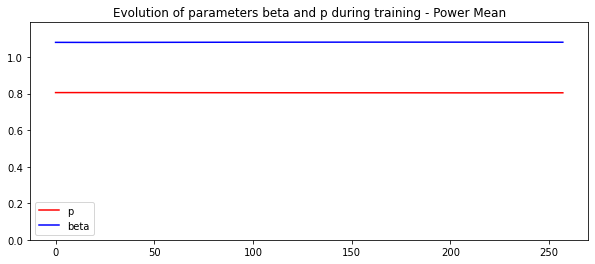

In [23]:
import matplotlib.pyplot as plt
p_epoch    = np.array([batch["p"] for batch in epoch_values]).flatten()
beta_epoch = np.array([batch["beta"] for batch in epoch_values]).flatten() 

plt.figure(figsize=(10,4))
plt.title("Evolution of parameters beta and p during training - Power Mean")
plt.plot(p_epoch, "r-", label="p")
plt.plot(beta_epoch, "b-", label="beta")
plt.ylim(0, 1.1*np.amax(np.maximum(p_epoch, beta_epoch)))
plt.legend()
plt.show()